In [1]:
import os

import numpy
import matplotlib
from matplotlib import pyplot
from matplotlib.gridspec import GridSpec
import pickle
import pandas
import scipy
import seaborn
import tensorflow
import tensorflow.keras
from tensorflow.keras.layers import Layer

from Bio import SeqIO

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
pandas.options.display.max_columns = None
pandas.options.display.max_colwidth = None

In [3]:
plt_fmt = 'svg'

In [4]:
data_filepath = 'gene_editing_results_and_seqs.xlsx'

In [5]:
# Names of datasets to compare
# Data will be extracted from the tabs in the datafile in the cell above
datasets = [
    'K562',
    'HepG2',
]

In [6]:
data_indel_datasets = []

for dataset in datasets:
    # Load editing data
    data_indel = pandas.read_excel(
        data_filepath,
        sheet_name=dataset,
    )
    data_indel['Dataset'] = dataset

    index_col = [
        'Dataset',
        'megaTAL',
        'mRNA pmol',
        'Sequence ID',
        'Sequence prefix',
        'Replicate',
    ]
    data_indel = data_indel.sort_values(index_col)
    data_indel = data_indel.set_index(index_col, drop=True)

    data_indel_datasets.append(data_indel)

data_indel = pandas.concat(data_indel_datasets)
data_indel

Indel %  \
Dataset megaTAL mRNA pmol Sequence ID Sequence prefix Replicate            
K562    PDCD1   0.25      1           GGG             1           0.1668   
                                                      2           0.1552   
                          2           GGG             1           0.3016   
                                                      2           0.3036   
                          3           GGG             1           0.4860   
...                                                                  ...   
HepG2   TGFBR2  2.00      46          GGG             2           0.1263   
                          47          GGG             1           0.1152   
                                                      2           0.1835   
                          48          GGG             1           0.1310   
                                                      2           0.2101   

                                                                 Flagged  
Dataset megaTAL mRNA pmol Sequence ID Sequence prefix Replicate           
K562    PDCD1   0.25      1           GGG             1              NaN  
                                                      2              NaN  
                          2           GGG             1              NaN  
                                                      2              NaN  
                          3           GGG             1              NaN  
...                                                                  ...  
HepG2   TGFBR2  2.00      46          GGG             2              NaN  
                          47          GGG             1              NaN  
                                                      2              NaN  
                          48          GGG             1              NaN  
                                                      2              NaN  

[1440 rows x 2 columns]

In [7]:
# Add stats

# Function to condition stat table to be added to the main data table
def condition_indel_stat(data_indel_stat, stat_name):
    # data_indel_stat is Series. Convert to DataFrame and give column name
    data_indel_stat = data_indel_stat.to_frame()
    data_indel_stat = data_indel_stat.rename(columns={0: 'Indel %'})
    # Add stat name as Replicate value, then move to index
    data_indel_stat['Replicate'] = stat_name
    data_indel_stat = data_indel_stat.reset_index().set_index(index_col)
    
    return data_indel_stat

# Make table with only indel data, then unstack replicate index
data_indel_all = data_indel['Indel %'].unstack(level=-1)
# Calculate stats
data_indel_all_mean = data_indel_all.mean(axis=1)
data_indel_all_std = data_indel_all.std(axis=1)

# Extract indel column, set to NaN if flagged
data_indel_nonflagged = data_indel['Indel %'].to_frame().copy()
data_indel_nonflagged.loc[data_indel['Flagged'].notnull(), 'Indel %'] = numpy.nan
# Unstack replicate index
data_indel_nonflagged = data_indel_nonflagged.unstack(level=-1)
# Calculate stats
data_indel_nonflagged_mean = data_indel_nonflagged.mean(axis=1)
data_indel_nonflagged_std = data_indel_nonflagged.std(axis=1)

# Add stats rows
data_indel = data_indel.append(condition_indel_stat(data_indel_all_mean, 'Mean'))
data_indel = data_indel.append(condition_indel_stat(data_indel_all_std, 'Std'))
data_indel = data_indel.append(condition_indel_stat(data_indel_nonflagged_mean, 'Mean nonflagged'))
data_indel = data_indel.append(condition_indel_stat(data_indel_nonflagged_std, 'Std nonflagged'))
# Resort index
data_indel = data_indel.reset_index().sort_values(index_col).set_index(index_col)

data_indel

C:\Users\casti\AppData\Local\Temp\ipykernel_42136\1919278361.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_indel = data_indel.append(condition_indel_stat(data_indel_all_mean, 'Mean'))
C:\Users\casti\AppData\Local\Temp\ipykernel_42136\1919278361.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_indel = data_indel.append(condition_indel_stat(data_indel_all_std, 'Std'))
C:\Users\casti\AppData\Local\Temp\ipykernel_42136\1919278361.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_indel = data_indel.append(condition_indel_stat(data_indel_nonflagged_mean, 'Mean nonflagged'))
C:\Users\casti\AppData\Local\Temp\ipykernel_42136\1919278361.py:33: FutureWarning: The frame.append method is deprecated and will

Indel %  \
Dataset megaTAL mRNA pmol Sequence ID Sequence prefix Replicate                   
HepG2   PDCD1   0.25      1           GGGGGG          1                0.012000   
                                                      2                0.002500   
                                                      Mean             0.007250   
                                                      Mean nonflagged  0.007250   
                                                      Std              0.006718   
...                                                                         ...   
K562    TGFBR2  2.00      48          GGG             2                0.393600   
                                                      Mean             0.398100   
                                                      Mean nonflagged  0.398100   
                                                      Std              0.006364   
                                                      Std nonflagged   0.006364   

                                                                       Flagged  
Dataset megaTAL mRNA pmol Sequence ID Sequence prefix Replicate                 
HepG2   PDCD1   0.25      1           GGGGGG          1                    NaN  
                                                      2                    NaN  
                                                      Mean                 NaN  
                                                      Mean nonflagged      NaN  
                                                      Std                  NaN  
...                                                                        ...  
K562    TGFBR2  2.00      48          GGG             2                    NaN  
                                                      Mean                 NaN  
                                                      Mean nonflagged      NaN  
                                                      Std                  NaN  
                                                      Std nonflagged       NaN  

[4320 rows x 2 columns]

In [8]:
# Add normalized indel % column
norm_seq_id = 48
megatal_values = data_indel.index.get_level_values('megaTAL').unique().sort_values(ascending=False)
mrna_pmol_values = data_indel.index.get_level_values('mRNA pmol').unique()

for dataset in datasets:
    for mrna_pmol in mrna_pmol_values:
        for megatal in megatal_values:
            # Filter data for current megata, mrna_pmol
            data_cond = data_indel[
                (data_indel.index.get_level_values('Dataset')==dataset) &\
                (data_indel.index.get_level_values('megaTAL')==megatal) &\
                (data_indel.index.get_level_values('mRNA pmol')==mrna_pmol)
            ]
            if len(data_cond) == 0:
                continue
            # Obtain value to normalize editing % to
            data_cond_norm = data_cond[data_cond.index.get_level_values('Sequence ID')==norm_seq_id]
            data_cond_norm_mean = data_cond_norm[
                (data_cond_norm.index.get_level_values('Replicate')=='Mean nonflagged')
            ]
            norm_value = data_cond_norm_mean['Indel %'].values[0]
            # Add to main table
            data_indel.loc[data_cond.index, 'Indel % (normalized)'] = data_cond['Indel %'] / norm_value

data_indel = data_indel[['Indel %', 'Indel % (normalized)', 'Flagged']]
data_indel

Indel %  \
Dataset megaTAL mRNA pmol Sequence ID Sequence prefix Replicate                   
HepG2   PDCD1   0.25      1           GGGGGG          1                0.012000   
                                                      2                0.002500   
                                                      Mean             0.007250   
                                                      Mean nonflagged  0.007250   
                                                      Std              0.006718   
...                                                                         ...   
K562    TGFBR2  2.00      48          GGG             2                0.393600   
                                                      Mean             0.398100   
                                                      Mean nonflagged  0.398100   
                                                      Std              0.006364   
                                                      Std nonflagged   0.006364   

                                                                       Indel % (normalized)  \
Dataset megaTAL mRNA pmol Sequence ID Sequence prefix Replicate                               
HepG2   PDCD1   0.25      1           GGGGGG          1                            0.180180   
                                                      2                            0.037538   
                                                      Mean                         0.108859   
                                                      Mean nonflagged              0.108859   
                                                      Std                          0.100864   
...                                                                                     ...   
K562    TGFBR2  2.00      48          GGG             2                            0.988696   
                                                      Mean                         1.000000   
                                                      Mean nonflagged              1.000000   
                                                      Std                          0.015986   
                                                      Std nonflagged               0.015986   

                                                                       Flagged  
Dataset megaTAL mRNA pmol Sequence ID Sequence prefix Replicate                 
HepG2   PDCD1   0.25      1           GGGGGG          1                    NaN  
                                                      2                    NaN  
                                                      Mean                 NaN  
                                                      Mean nonflagged      NaN  
                                                      Std                  NaN  
...                                                                        ...  
K562    TGFBR2  2.00      48          GGG             2                    NaN  
                                                      Mean                 NaN  
                                                      Mean nonflagged      NaN  
                                                      Std                  NaN  
                                                      Std nonflagged       NaN  

[4320 rows x 3 columns]

In [9]:
# Point check a few sequences
# Sequence with no flagged replicates
display(data_indel.loc[('K562', 'TGFBR2', 2, 2, slice(None), slice(None))])
# Sequence with one flagged replicate
display(data_indel.loc[('K562', 'TGFBR2', 2, 1, slice(None), slice(None))])
# Sequence with two flagged replicates
display(data_indel.loc[('K562', 'TGFBR2', 0.25, 5, slice(None), slice(None))])

# HepG2 sequences
display(data_indel.loc[('HepG2', 'TGFBR2', 2, 2, slice(None), slice(None))])
# Sequence with one flagged replicate
display(data_indel.loc[('HepG2', 'TGFBR2', 2, 1, slice(None), slice(None))])
# Sequence with two flagged replicates
display(data_indel.loc[('HepG2', 'PDCD1', 0.25, 5, slice(None), slice(None))])

Indel %  Indel % (normalized)  Flagged
Sequence prefix Replicate                                               
GGG             1                0.213400              0.536046      NaN
                2                0.197000              0.494851      NaN
                Mean             0.205200              0.515448      NaN
                Mean nonflagged  0.205200              0.515448      NaN
                Std              0.011597              0.029130      NaN
                Std nonflagged   0.011597              0.029130      NaN

Indel %  Indel % (normalized)  Flagged
Sequence prefix Replicate                                               
GGG             1                0.065700              0.165034      NaN
                2                0.005400              0.013564      1.0
                Mean             0.035550              0.089299      NaN
                Mean nonflagged  0.065700              0.165034      NaN
                Std              0.042639              0.107105      NaN
                Std nonflagged        NaN                   NaN      NaN

Indel %  Indel % (normalized)  Flagged
Sequence prefix Replicate                                               
GGG             1                0.002200              0.022290      1.0
                2                0.002500              0.025329      1.0
                Mean             0.002350              0.023810      NaN
                Mean nonflagged       NaN                   NaN      NaN
                Std              0.000212              0.002149      NaN
                Std nonflagged        NaN                   NaN      NaN

Indel %  Indel % (normalized)  Flagged
Sequence prefix Replicate                                               
GGGGGG          1                0.031300              0.183524      NaN
                2                0.052300              0.306655      NaN
                Mean             0.041800              0.245089      NaN
                Mean nonflagged  0.041800              0.245089      NaN
                Std              0.014849              0.087067      NaN
                Std nonflagged   0.014849              0.087067      NaN

Indel %  Indel % (normalized)  Flagged
Sequence prefix Replicate                                               
GGGGGG          1                0.005400              0.031662      NaN
                2                0.011100              0.065084      NaN
                Mean             0.008250              0.048373      NaN
                Mean nonflagged  0.008250              0.048373      NaN
                Std              0.004031              0.023632      NaN
                Std nonflagged   0.004031              0.023632      NaN

Indel %  Indel % (normalized)  Flagged
Sequence prefix Replicate                                               
GGGGGG          1                0.080400              1.207207      NaN
                2                0.113900              1.710210      NaN
                Mean             0.097150              1.458709      NaN
                Mean nonflagged  0.097150              1.458709      NaN
                Std              0.023688              0.355677      NaN
                Std nonflagged   0.023688              0.355677      NaN

In [10]:
# Load sequence data
data_seqs = pandas.read_excel(
    data_filepath,
    sheet_name="5'UTR sequences",
)

# Duplicate and add prefix
data_seqs_g3 = data_seqs.copy()
data_seqs_g3['Sequence prefix'] = 'GGG'

data_seqs_g6 = data_seqs.copy()
data_seqs_g6['Sequence prefix'] = 'GGGGGG'

data_seqs = pandas.concat([data_seqs_g3, data_seqs_g6], axis=0)
data_seqs_index = ['Sequence ID', 'Sequence prefix']
data_seqs = data_seqs.reset_index(drop=True).sort_values(data_seqs_index).set_index(data_seqs_index)

data_seqs

5'UTR  \
Sequence ID Sequence prefix                                                                                                           
1           GGG                                            ACATCGTAGAGAGTCGTACTTAAGGGATGCCACCGTTTAAAGGATATCTCGGTATGGCCTGGGTAAGCTTCC   
            GGGGGG                                         ACATCGTAGAGAGTCGTACTTAAGGGATGCCACCGTTTAAAGGATATCTCGGTATGGCCTGGGTAAGCTTCC   
2           GGG                                            ACATCGTAGAGAGTCGTACTTAACTCTAGAGTCAGGCATTCTGTGAAATGGACATGGGCGAAGTAGGACCTA   
            GGGGGG                                         ACATCGTAGAGAGTCGTACTTAACTCTAGAGTCAGGCATTCTGTGAAATGGACATGGGCGAAGTAGGACCTA   
3           GGG                                            ACATCGTAGAGAGTCGTACTTACAGCTCCTGCCAACGCAGAAGGCACCTATGCACTCTCGGACCGCGTCTCC   
...                                                                                                                             ...   
46          GGGGGG           GCTGGATCCCGCAGCCGCGGCTCTTCCCGACGCGTTCCGCCTTCCCCAGCTGTGCACTCTCCATCCAGCTGTGCGCTCTCGTCGGGAGTCCCAGCCGCCACC   
47          GGG                                           AGACCCGCCGGGCTCCCGCCGCGCGCGCTGTCCCTGGAGCTCGGGGACGCGGCCCGGAGCCGGGAAGGCCACC   
            GGGGGG                                        AGACCCGCCGGGCTCCCGCCGCGCGCGCTGTCCCTGGAGCTCGGGGACGCGGCCCGGAGCCGGGAAGGCCACC   
48          GGG                                                                                                              GCCACC   
            GGGGGG                                                                                                           GCCACC   

                             Measured MRL  Predicted MRL  \
Sequence ID Sequence prefix                                
1           GGG                  2.142014       1.869994   
            GGGGGG               2.142014       1.869994   
2           GGG                  3.497435       3.500646   
            GGGGGG               3.497435       3.500646   
3           GGG                  5.000827       5.002466   
...                                   ...            ...   
46          GGGGGG                    NaN            NaN   
47          GGG                       NaN            NaN   
            GGGGGG                    NaN            NaN   
48          GGG                       NaN            NaN   
            GGGGGG                    NaN            NaN   

                                        Description  
Sequence ID Sequence prefix                          
1           GGG              N50, MPRA, varying MRL  
            GGGGGG           N50, MPRA, varying MRL  
2           GGG              N50, MPRA, varying MRL  
            GGGGGG           N50, MPRA, varying MRL  
3           GGG              N50, MPRA, varying MRL  
...                                             ...  
46          GGGGGG                             VAT1  
47          GGG                               LAMA5  
            GGGGGG                            LAMA5  
48          GGG                        Strong Kozak  
            GGGGGG                     Strong Kozak  

[96 rows x 4 columns]

In [11]:
# Get description of sequence used for normalization
norm_seq_desc = data_seqs.loc[(norm_seq_id, 'GGG'), 'Description']
norm_seq_desc

'Strong Kozak'

# Analysis

In [12]:
# Add information from sequence table to indel data table
seq_indexes = data_indel.reset_index()[['Sequence ID', 'Sequence prefix']].values
seq_indexes = [(index[0], index[1]) for index in seq_indexes]
# print(seq_indexes)

data_indel["5'UTR description"] = data_seqs.loc[seq_indexes]['Description'].values
data_indel["Measured MRL"] = data_seqs.loc[seq_indexes]['Measured MRL'].values
data_indel["Predicted MRL (CNN)"] = data_seqs.loc[seq_indexes]['Predicted MRL'].values

display(data_indel)

C:\Users\casti\AppData\Local\Temp\ipykernel_42136\420398592.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_indel["5'UTR description"] = data_seqs.loc[seq_indexes]['Description'].values
C:\Users\casti\AppData\Local\Temp\ipykernel_42136\420398592.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_indel["Measured MRL"] = data_seqs.loc[seq_indexes]['Measured MRL'].values
C:\Users\casti\AppData\Local\Temp\ipykernel_42136\420398592.py:8: SettingWithCopyWarning: 
A value is trying to be set on a co

Indel %  \
Dataset megaTAL mRNA pmol Sequence ID Sequence prefix Replicate                   
HepG2   PDCD1   0.25      1           GGGGGG          1                0.012000   
                                                      2                0.002500   
                                                      Mean             0.007250   
                                                      Mean nonflagged  0.007250   
                                                      Std              0.006718   
...                                                                         ...   
K562    TGFBR2  2.00      48          GGG             2                0.393600   
                                                      Mean             0.398100   
                                                      Mean nonflagged  0.398100   
                                                      Std              0.006364   
                                                      Std nonflagged   0.006364   

                                                                       Indel % (normalized)  \
Dataset megaTAL mRNA pmol Sequence ID Sequence prefix Replicate                               
HepG2   PDCD1   0.25      1           GGGGGG          1                            0.180180   
                                                      2                            0.037538   
                                                      Mean                         0.108859   
                                                      Mean nonflagged              0.108859   
                                                      Std                          0.100864   
...                                                                                     ...   
K562    TGFBR2  2.00      48          GGG             2                            0.988696   
                                                      Mean                         1.000000   
                                                      Mean nonflagged              1.000000   
                                                      Std                          0.015986   
                                                      Std nonflagged               0.015986   

                                                                       Flagged  \
Dataset megaTAL mRNA pmol Sequence ID Sequence prefix Replicate                  
HepG2   PDCD1   0.25      1           GGGGGG          1                    NaN   
                                                      2                    NaN   
                                                      Mean                 NaN   
                                                      Mean nonflagged      NaN   
                                                      Std                  NaN   
...                                                                        ...   
K562    TGFBR2  2.00      48          GGG             2                    NaN   
                                                      Mean                 NaN   
                                                      Mean nonflagged      NaN   
                                                      Std                  NaN   
                                                      Std nonflagged       NaN   

                                                                            5'UTR description  \
Dataset megaTAL mRNA pmol Sequence ID Sequence prefix Replicate                                 
HepG2   PDCD1   0.25      1           GGGGGG          1                N50, MPRA, varying MRL   
                                                      2                N50, MPRA, varying MRL   
                                                      Mean             N50, MPRA, varying MRL   
                                                      Mean nonflagged  N50, MPRA, varying MRL   
                                                      Std              N50, MPRA, varying MRL   
...       

In [13]:
# Get averages of normalized editing % across all replicates and mRNA concentrations

# Filter by actual rep data, non-flagged
data_indel_repnf = data_indel[
    (data_indel.index.get_level_values('Replicate').astype(str).str.isnumeric()) &\
    (data_indel['Flagged'].isnull())
]

# Get average and std per dataset, sequence ID, and megaTAL, ignoring mRNA pmol
data_indel_avemrna_all = data_indel_repnf['Indel % (normalized)'].unstack(level=['mRNA pmol', 'Replicate'])
data_indel_avemrna_mean = data_indel_avemrna_all.mean(axis=1)
data_indel_avemrna_std = data_indel_avemrna_all.std(axis=1)
data_indel_avemrna = pandas.concat([data_indel_avemrna_mean, data_indel_avemrna_std], axis=1)
data_indel_avemrna.columns = ['Mean normalized indel %', 'Std normalized indel %']

# Add sequence metadata
seq_indexes = data_indel_avemrna.reset_index()[['Sequence ID', 'Sequence prefix']].values
seq_indexes = [(index[0], index[1]) for index in seq_indexes]

data_indel_avemrna["5'UTR sequence"] = data_seqs.loc[seq_indexes]["5'UTR"].values
data_indel_avemrna["5'UTR description"] = data_seqs.loc[seq_indexes]['Description'].values
data_indel_avemrna["Measured MRL"] = data_seqs.loc[seq_indexes]['Measured MRL'].values
data_indel_avemrna["Predicted MRL (CNN)"] = data_seqs.loc[seq_indexes]['Predicted MRL'].values

display(data_indel_avemrna_all)
display(data_indel_avemrna)

mRNA pmol                                        0.25                0.50  \
Replicate                                           1         2         1   
Dataset megaTAL Sequence ID Sequence prefix                                 
HepG2   PDCD1   1           GGGGGG           0.180180  0.037538  0.036176   
                2           GGGGGG           1.259760  1.148649  0.433247   
                3           GGGGGG           1.232733  0.061562  0.495263   
                4           GGGGGG           2.319820  1.361862  1.243755   
                5           GGGGGG           1.207207  1.710210  0.765719   
...                                               ...       ...       ...   
K562    TGFBR2  44          GGG              0.875380  0.825735  1.237898   
                45          GGG                   NaN       NaN  1.239669   
                46          GGG              0.847011  0.878419  0.866588   
                47          GGG              1.297872  1.490375  1.361275   
                48          GGG              0.976697  1.023303  0.943329   

mRNA pmol                                                  1.00            \
Replicate                                           2         1         2   
Dataset megaTAL Sequence ID Sequence prefix                                 
HepG2   PDCD1   1           GGGGGG           0.145564  0.303012  0.522150   
                2           GGGGGG           0.203273  0.402835  0.653278   
                3           GGGGGG           0.750215  0.946249  0.769049   
                4           GGGGGG           1.126615  1.076196  1.168340   
                5           GGGGGG           1.119724  1.342587  0.816893   
...                                               ...       ...       ...   
K562    TGFBR2  44          GGG              1.124557  1.035170  0.979500   
                45          GGG              1.185950  1.244687  1.131841   
                46          GGG              1.002361  0.969344  1.020500   
                47          GGG              1.400236  1.167200  1.205943   
                48          GGG              1.056671  1.016739  0.983261   

mRNA pmol                                        2.00            
Replicate                                           1         2  
Dataset megaTAL Sequence ID Sequence prefix                      
HepG2   PDCD1   1           GGGGGG           0.562703  0.682353  
                2           GGGGGG           0.878598  0.752441  
                3           GGGGGG           1.052315  0.880601  
                4           GGGGGG           1.374718  1.292616  
                5           GGGGGG           0.832040  1.224030  
...                                               ...       ...  
K562    TGFBR2  44          GGG              0.850540  0.831701  
                45          GGG              1.193168  1.088420  
                46          GGG              0.967094  0.950013  
                47          GGG              1.208490  1.137905  
                48          GGG              1.011304  0.988696  

[192 rows x 8 columns]

Mean normalized indel %  \
Dataset megaTAL Sequence ID Sequence prefix                            
HepG2   PDCD1   1           GGGGGG                          0.308710   
                2           GGGGGG                          0.716510   
                3           GGGGGG                          0.773498   
                4           GGGGGG                          1.370490   
                5           GGGGGG                          1.127301   
...                                                              ...   
K562    TGFBR2  44          GGG                             0.970060   
                45          GGG                             1.180623   
                46          GGG                             0.937666   
                47          GGG                             1.283662   
                48          GGG                             1.000000   

                                             Std normalized indel %  \
Dataset megaTAL Sequence ID Sequence prefix                           
HepG2   PDCD1   1           GGGGGG                         0.250900   
                2           GGGGGG                         0.369453   
                3           GGGGGG                         0.361501   
                4           GGGGGG                         0.398281   
                5           GGGGGG                         0.319867   
...                                                             ...   
K562    TGFBR2  44          GGG                            0.152670   
                45          GGG                            0.061086   
                46          GGG                            0.065301   
                47          GGG                            0.124811   
                48          GGG                            0.034486   

                                                                                                                                     5'UTR sequence  \
Dataset megaTAL Sequence ID Sequence prefix                                                                                                           
HepG2   PDCD1   1           GGGGGG                                         ACATCGTAGAGAGTCGTACTTAAGGGATGCCACCGTTTAAAGGATATCTCGGTATGGCCTGGGTAAGCTTCC   
                2           GGGGGG                                         ACATCGTAGAGAGTCGTACTTAACTCTAGAGTCAGGCATTCTGTGAAATGGACATGGGCGAAGTAGGACCTA   
                3           GGGGGG                                         ACATCGTAGAGAGTCGTACTTACAGCTCCTGCCAACGCAGAAGGCACCTATGCACTCTCGGACCGCGTCTCC   
                4           GGGGGG                                         ACATCGTAGAGAGTCGTACTTACCGGCAAGGGGTCCGGGGGTCTCCAACGCAGGAGCACACCGCAAGCTTAG   
                5           GGGGGG                                         ACATCGTAGAGAGTCGTACTTACAAGAGTGCAAGACACGCTCAGAAGTTAACAAAGACTTAGCGACACCGTC   
...                                                                                                                                             ...   
K562    TGFBR2  44          GGG                                                                                           TTCGCGAGAGAGGGAATTATACGTT   
                45          GGG                                                                                           TTCACGCGAGAGGACTGCGAGGACA   
                46          GGG              GCTGGATCCCGCAGCCGCGGCTCTTCCCGACGCGTTCCGCCTTCCCCAGCTGTGCACTCTCCATCCAGCTGTGCGCTCTCGTCGGGAGTCCCAGCCGCCACC   
                47          GGG                                           AGACCCGCCGGGCTCCCGCCGCGCGCGCTGTCCCTGGAGCTCGGGGACGCGGCCCGGAGCCGGGAAGGCCACC   
                48          GGG                                                                                                              GCCACC   

                                                  5'UTR description  \
Dataset megaTAL Sequence ID Sequence prefix                           
HepG2   PDCD1   1           GGGGGG           N50, MPRA, varying MRL   
       

In [14]:
# Get percentage of improvement over strong kozak control, PDCD1 gene
data_to_analyze = data_indel.loc[('K562', 'PDCD1')]
data_to_analyze = data_to_analyze.iloc[data_to_analyze.index.get_level_values('Replicate')=='Mean']
data_to_analyze.index = data_to_analyze.index.droplevel([2, 3])
data_to_analyze = data_to_analyze.unstack(-1)
# data_to_analyze[('Indel %', 39)] / data_to_analyze[('Indel %', 48)]

data_to_analyze[('Indel %', 46)] / data_to_analyze[('Indel %', 48)]

mRNA pmol
0.25    1.463851
0.50    1.302659
1.00    1.196336
2.00    1.099441
dtype: float64

In [15]:
# Get percentage of improvement over strong kozak control, TGFBR2 gene
data_to_analyze = data_indel.loc[('K562', 'TGFBR2')]
data_to_analyze = data_to_analyze.iloc[data_to_analyze.index.get_level_values('Replicate')=='Mean']
data_to_analyze.index = data_to_analyze.index.droplevel([2, 3])
data_to_analyze = data_to_analyze.unstack(-1)
data_to_analyze[('Indel %', 39)] / data_to_analyze[('Indel %', 48)]

mRNA pmol
0.25    1.816616
0.50    1.710153
1.00    1.577957
2.00    1.395755
dtype: float64

In [16]:
# Save summary per-sequence mean/std table
data_indel_avemrna.to_csv('summary_mean_std.csv')

# Generate Plots

In [16]:
# Colors based on design method
seq_colors_dict = {
    'N50, MPRA, varying MRL': 'darkgoldenrod',
    'N50, MPRA, high MRL': 'tab:purple',
    'N25, MPRA, high MRL': 'purple',
    'N50, SeqProp': 'tab:blue',
    'N50, SeqProp+VAE': 'tab:green',
    'N25, SeqProp': 'tab:blue',
    'N25, SeqProp+VAE': 'tab:green',
    'N50, DEN': 'tab:red',
    'N50, DEN+VAE': 'tab:orange',
    'N50, DEN, varying MRL': 'gold',
    'N25, DEN': 'tab:red',
    'N25, DEN+VAE': 'tab:orange',
    'VAT1': 'lightgray',
    'LAMA5': 'darkgray',
    'Strong Kozak': 'dimgray',
}

seq_markers_dict = {
    'N50, MPRA, varying MRL': 'o',
    'N50, MPRA, high MRL': 'o',
    'N25, MPRA, high MRL': 's',
    'N50, SeqProp': 'o',
    'N50, SeqProp+VAE': 'o',
    'N25, SeqProp': 's',
    'N25, SeqProp+VAE': 's',
    'N50, DEN': 'o',
    'N50, DEN+VAE': 'o',
    'N50, DEN, varying MRL': 'o',
    'N25, DEN': 's',
    'N25, DEN+VAE': 's',
    'VAT1': 'v',
    'LAMA5': '^',
    'Strong Kozak': 'D',
}

In [17]:
description_sets_to_plot = {
    'all': [
        'N50, MPRA, varying MRL',
        'N50, MPRA, high MRL',
        'N25, MPRA, high MRL',
        'N50, SeqProp',
        'N50, SeqProp+VAE',
        'N25, SeqProp',
        'N25, SeqProp+VAE',
        'N50, DEN',
        'N50, DEN+VAE',
        'N50, DEN, varying MRL',
        'N25, DEN',
        'N25, DEN+VAE',
        'VAT1',
        'LAMA5',
        'Strong Kozak',
    ],
    'n50_only': [
        'N50, MPRA, varying MRL',
        'N50, MPRA, high MRL',
        # 'N25, MPRA, high MRL',
        'N50, SeqProp',
        'N50, SeqProp+VAE',
        # 'N25, SeqProp',
        # 'N25, SeqProp+VAE',
        'N50, DEN',
        'N50, DEN+VAE',
        # 'N50, DEN, varying MRL',
        # 'N25, DEN',
        # 'N25, DEN+VAE',
        'VAT1',
        'LAMA5',
        'Strong Kozak',
    ],
    'n50_only_plus_varying': [
        'N50, MPRA, varying MRL',
        'N50, MPRA, high MRL',
        # 'N25, MPRA, high MRL',
        'N50, SeqProp',
        'N50, SeqProp+VAE',
        # 'N25, SeqProp',
        # 'N25, SeqProp+VAE',
        'N50, DEN',
        'N50, DEN+VAE',
        'N50, DEN, varying MRL',
        # 'N25, DEN',
        # 'N25, DEN+VAE',
        'VAT1',
        'LAMA5',
        'Strong Kozak',
    ],
    'n50_varying': [
        'N50, MPRA, varying MRL',
        'N50, MPRA, high MRL',
        # 'N25, MPRA, high MRL',
        # 'N50, SeqProp',
        # 'N50, SeqProp+VAE',
        # 'N25, SeqProp',
        # 'N25, SeqProp+VAE',
        # 'N50, DEN',
        # 'N50, DEN+VAE',
        'N50, DEN, varying MRL',
        # 'N25, DEN',
        # 'N25, DEN+VAE',
        'VAT1',
        'LAMA5',
        'Strong Kozak',
    ],
    'n25_only': [
        # 'N50, MPRA, varying MRL',
        # 'N50, MPRA, high MRL',
        'N25, MPRA, high MRL',
        # 'N50, SeqProp',
        # 'N50, SeqProp+VAE',
        'N25, SeqProp',
        'N25, SeqProp+VAE',
        # 'N50, DEN',
        # 'N50, DEN+VAE',
        # 'N50, DEN, varying MRL',
        'N25, DEN',
        'N25, DEN+VAE',
        'VAT1',
        'LAMA5',
        'Strong Kozak',
    ],
}

In [18]:
def plot_editing_norm(data_to_plot, figsize=None, ylim_norm=None):
    """
    Make a figure with absolute and normalized editing efficiency bar plots.

    Top panel shows absolute editing efficiencies, grouped by sequence and
    sorted by mRNA dose. The mean of replicates is plotted as a bar, and the
    individual replicate efficiencies are plotted as scatter markers. The
    bottom panel shows similar data but normalized to the efficiency of a
    specified sequence for each given mRNA amount. A horizontal line is plotted
    at y=1.

    """
    # Separate data from replicates and mean
    data_to_plot_mean = data_to_plot.xs('Mean', level='Replicate')
    
    # Set figure, axes
    if figsize is None:
        n_col_groups = len(data_to_plot_mean.index.get_level_values('Sequence ID').unique())
        figsize = (n_col_groups/4, 4.25)
    fig, axes = pyplot.subplots(2, 1, figsize=figsize)

    # Plot indel efficiencies
    descriptions = []
    for seq_idx, seq_id in enumerate(data_to_plot.index.get_level_values('Sequence ID').unique()):
        
        data_seq = data_to_plot.xs(seq_id, level='Sequence ID')
        data_seq = data_seq.sort_index(level='mRNA pmol')
        
        data_seq_reps = data_seq[
            data_seq.index.get_level_values('Replicate').astype(str).str.isnumeric()
        ]
        data_seq_mean = data_seq.xs('Mean', level='Replicate')
    
        data_seq_description = data_seq["5'UTR description"].values[0]

        xpos = seq_idx + 1 - 0.5 + numpy.arange(len(data_seq_mean)+2)[1:-1]/(len(data_seq_mean) + 1)
        
        axes[0].bar(
            xpos,
            data_seq_mean['Indel %'].values*100,
            color=seq_colors_dict[data_seq_description],
            width=0.13,
        )
        reps_indices = data_seq_reps.index.get_level_values('Replicate').unique()
        for rep_idx, rep_index in enumerate(reps_indices):
            data_seq_rep = data_seq_reps.xs(rep_index, level='Replicate')
            axes[0].scatter(
                xpos - 0.03 + 0.06*rep_idx/(len(reps_indices)-1),
                data_seq_rep["Indel %"].values*100,
                c=seq_colors_dict[data_seq_description],
                marker=seq_markers_dict[data_seq_description],
                s=10,
                edgecolor='k',
                zorder=100,
            )
        
        axes[1].bar(
            xpos,
            data_seq_mean['Indel % (normalized)'].values,
            color=seq_colors_dict[data_seq_description],
            width=0.13,
        )
        reps_indices = data_seq_reps.index.get_level_values('Replicate').unique()
        for rep_idx, rep_index in enumerate(reps_indices):
            data_seq_rep = data_seq_reps.xs(rep_index, level='Replicate')
            axes[1].scatter(
                xpos - 0.03 + 0.06*rep_idx/(len(reps_indices)-1),
                data_seq_rep["Indel % (normalized)"].values,
                c=seq_colors_dict[data_seq_description],
                marker=seq_markers_dict[data_seq_description],
                s=10,
                edgecolor='k',
                zorder=100,
            )
        
        descriptions.append(data_seq_description)

    # x ticks only when 5'UTR description changes
    axes[0].set_xticks(range(1, len(descriptions)+1))
    axes[1].set_xticks(range(1, len(descriptions)+1))
    xticklabels = descriptions
    for i in range(len(xticklabels) - 1, 0, -1):
        if xticklabels[i]==xticklabels[i-1]:
            xticklabels[i] = ''
    axes[0].set_xticklabels([])
    axes[1].set_xticklabels(xticklabels)
    pyplot.setp(
        axes[1].get_xticklabels(),
        rotation=60,
        ha="right",
        rotation_mode="anchor",
    )

    # Horizontal line at normalization control level
    norm_description = data_to_plot_mean[
        data_to_plot_mean.index.get_level_values('Sequence ID')==norm_seq_id
    ]["5'UTR description"].values[0]
    axes[1].axhline(
        1,
        color=seq_colors_dict[norm_description],
        zorder=-1,
    )

    axes[0].set_ylabel("Editing %")
    axes[1].set_ylabel(f"Editing % (normalized\nto {norm_description})")
    axes[0].set_xlim(0, len(descriptions)+1)
    axes[1].set_xlim(0, len(descriptions)+1)
    if ylim_norm is not None:
        axes[1].set_ylim(ylim_norm)
    
    return fig

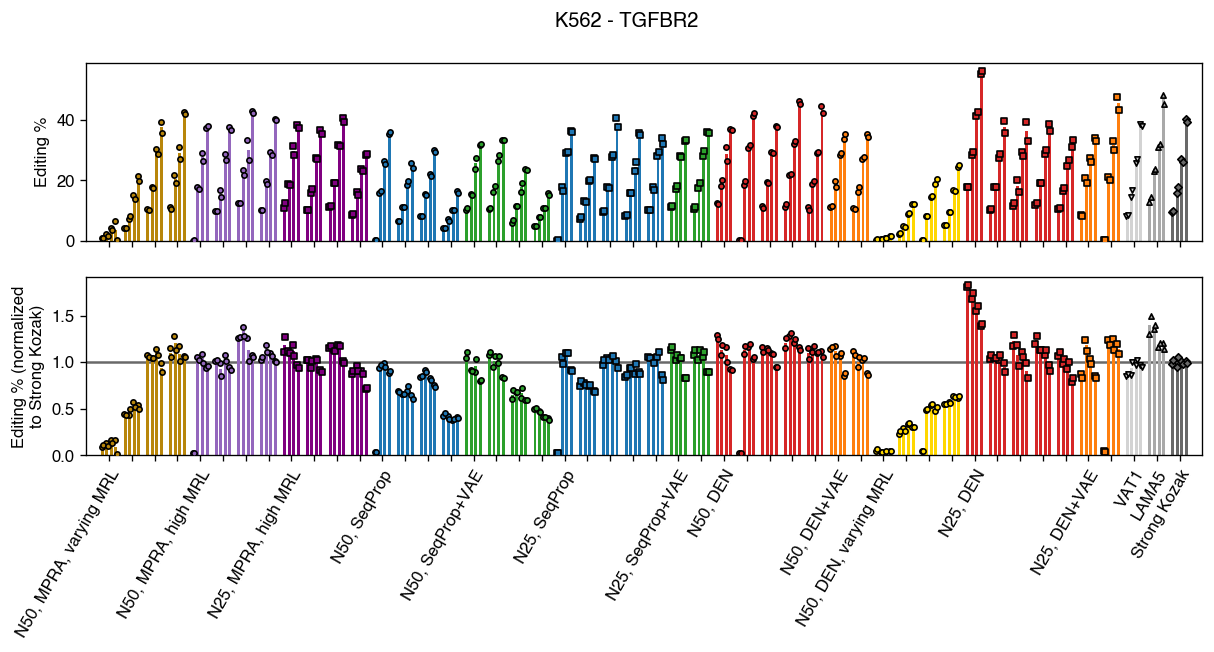

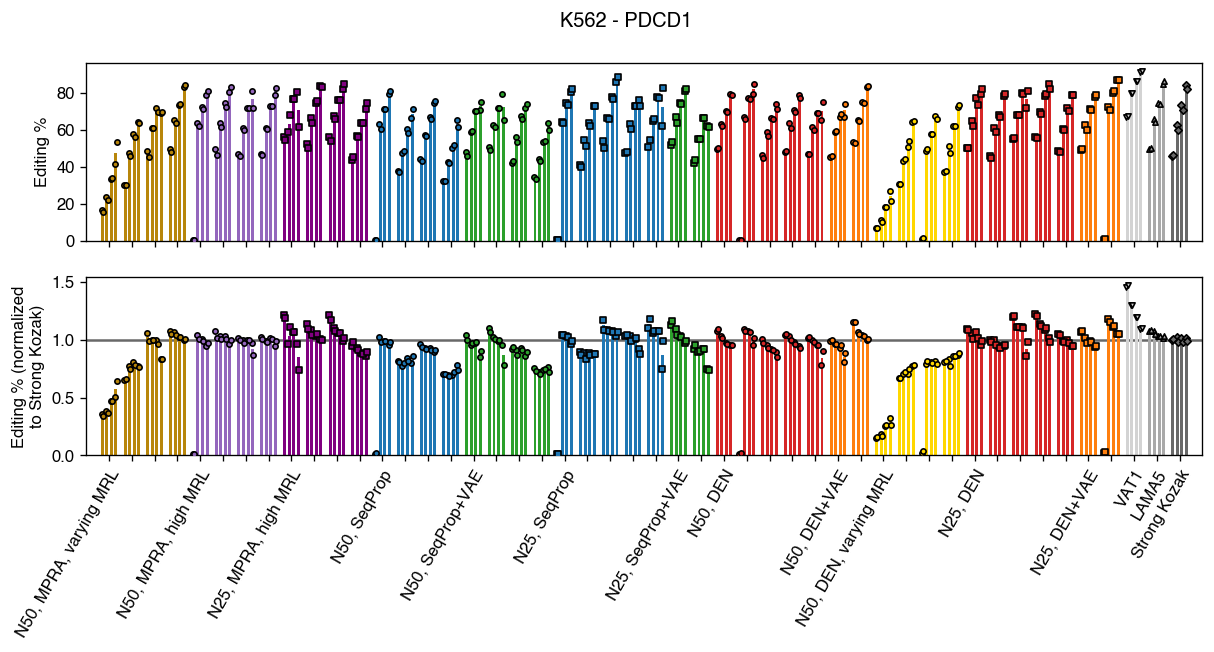

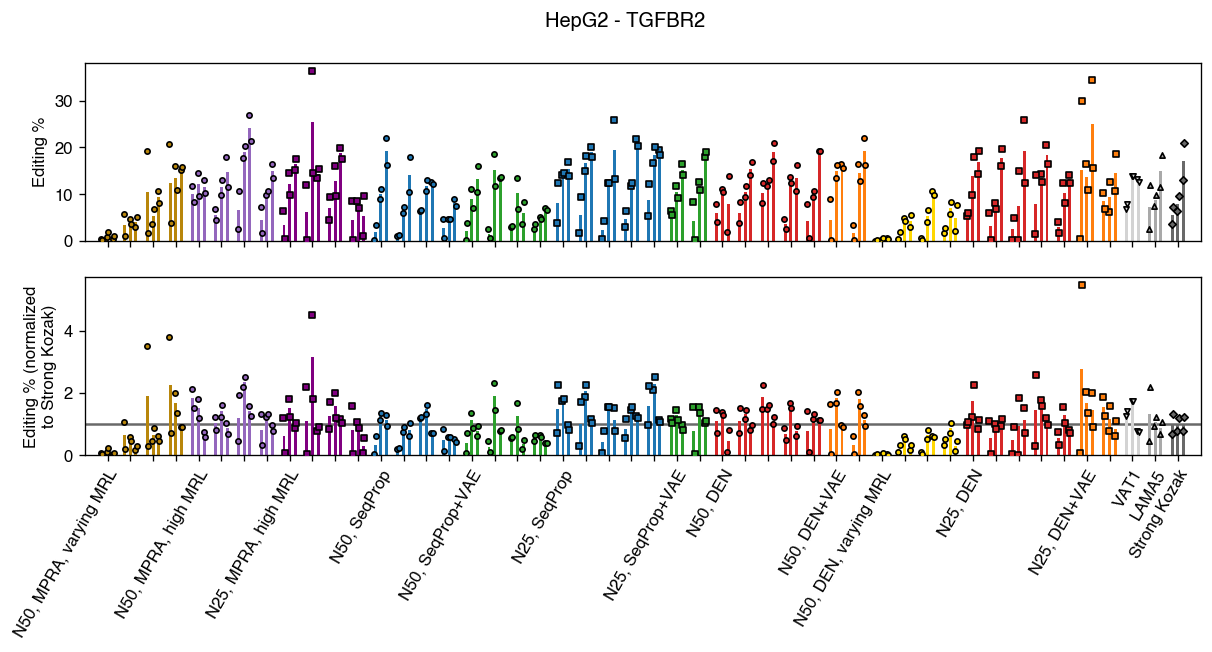

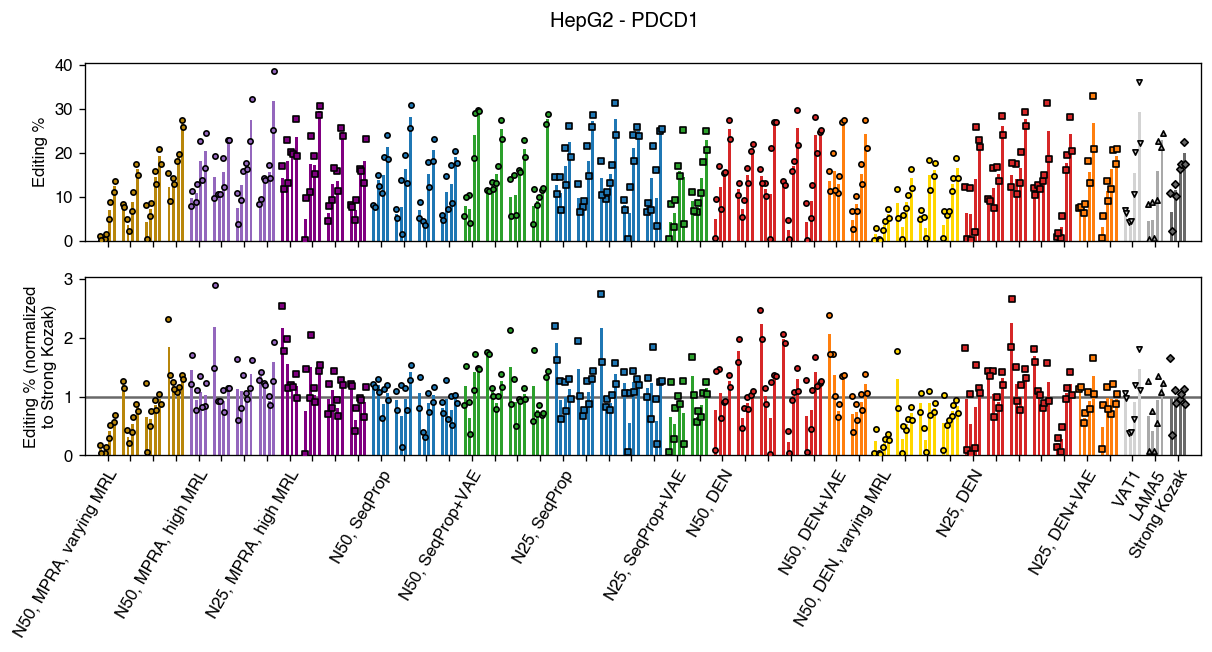

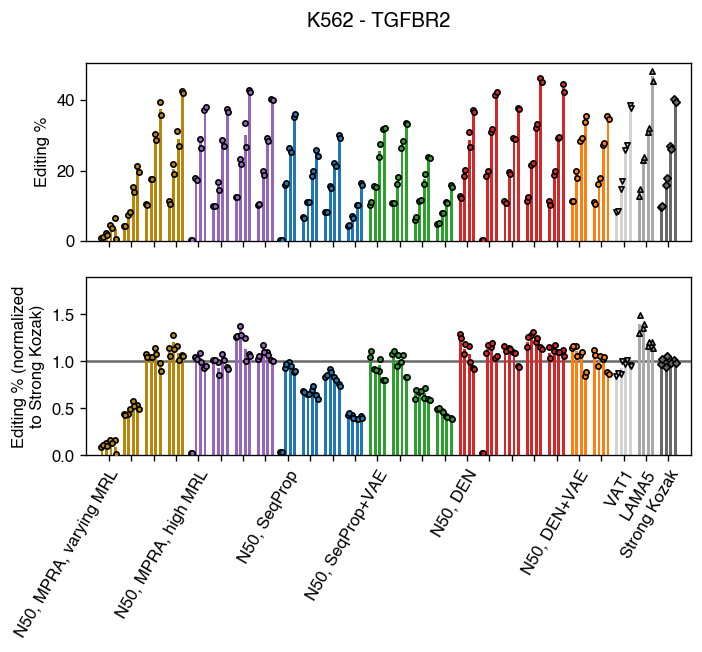

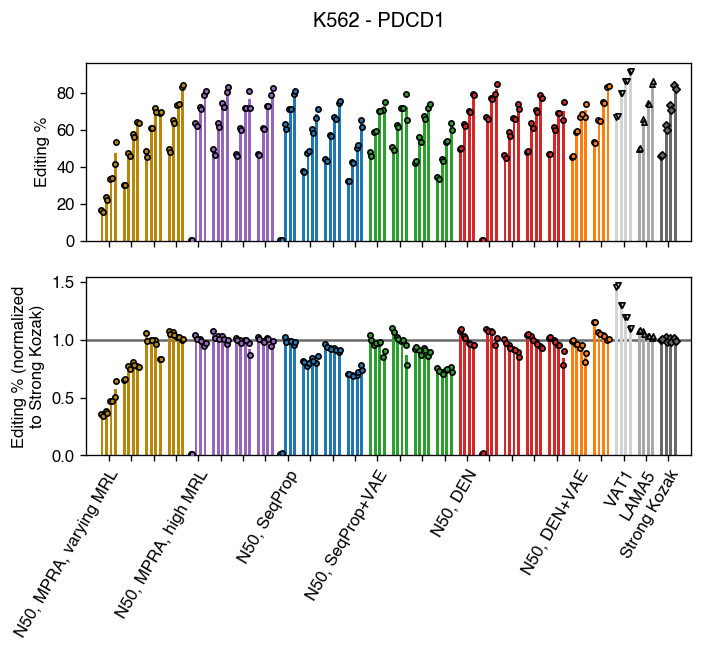

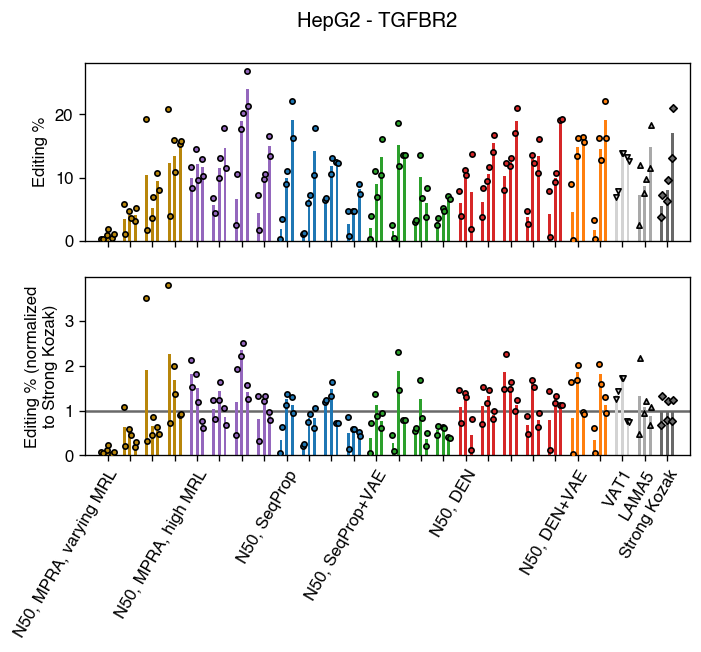

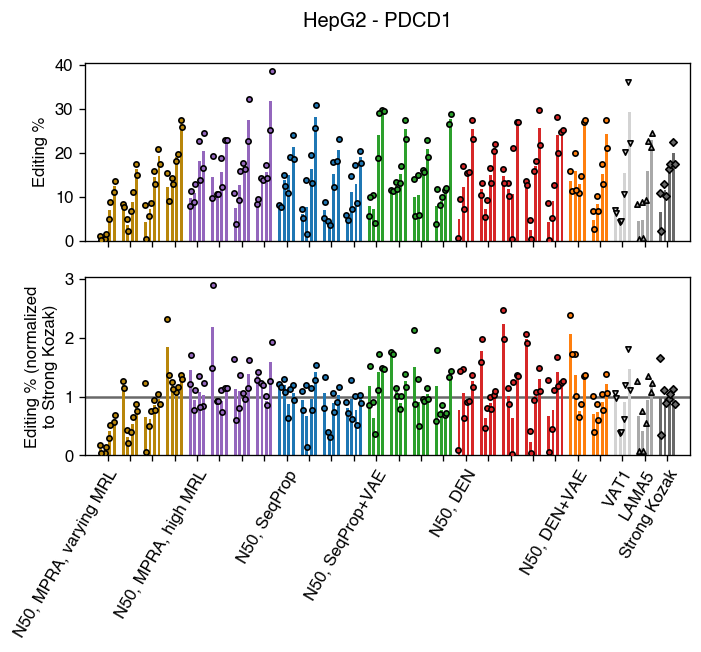

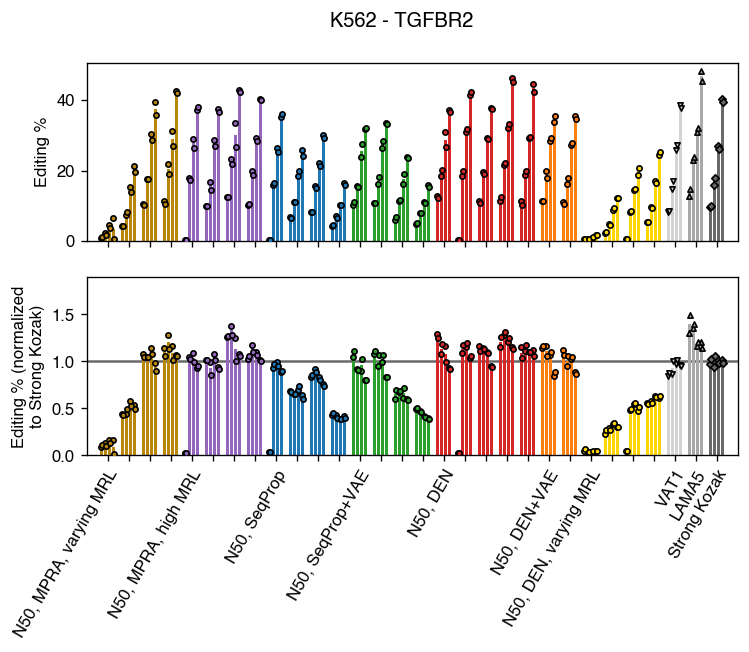

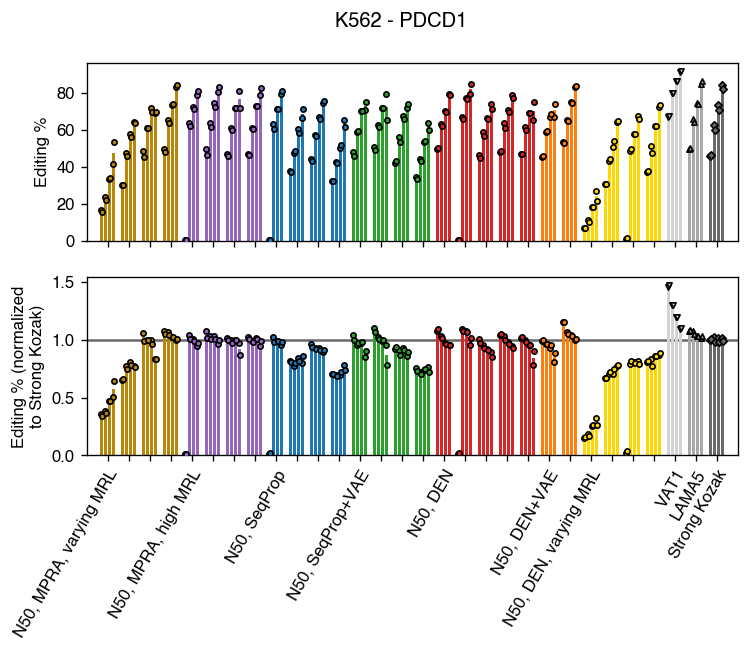

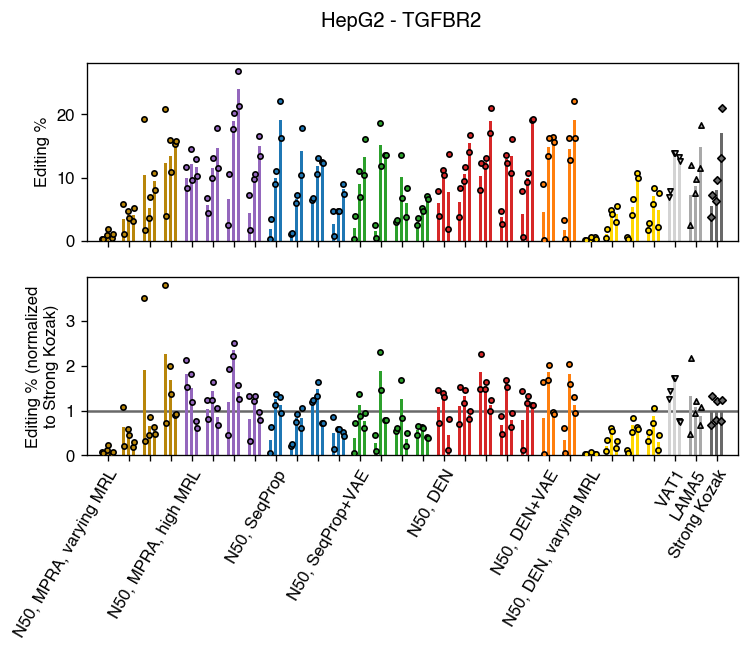

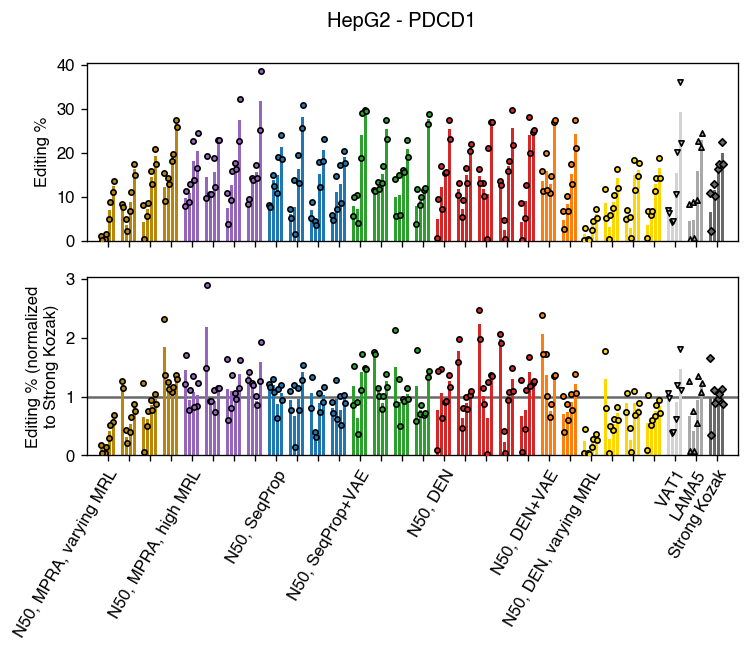

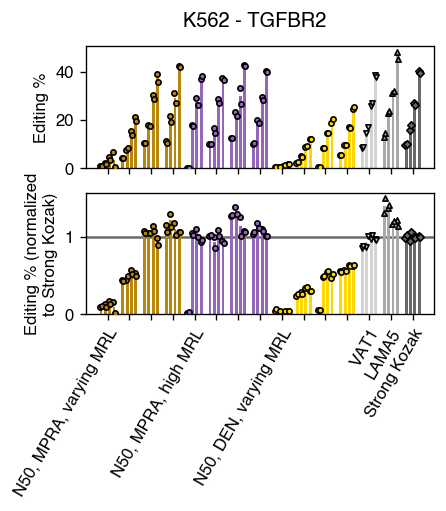

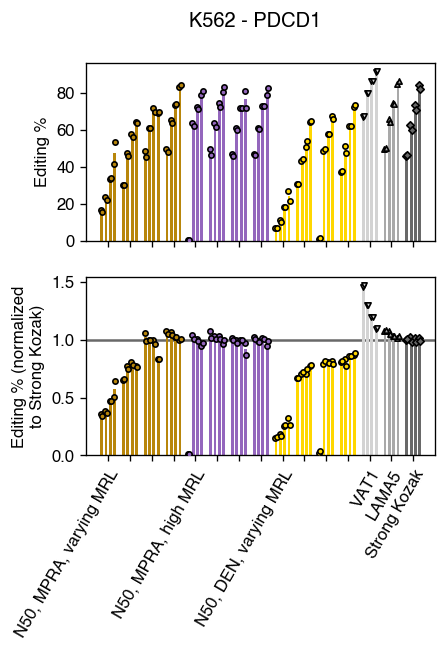

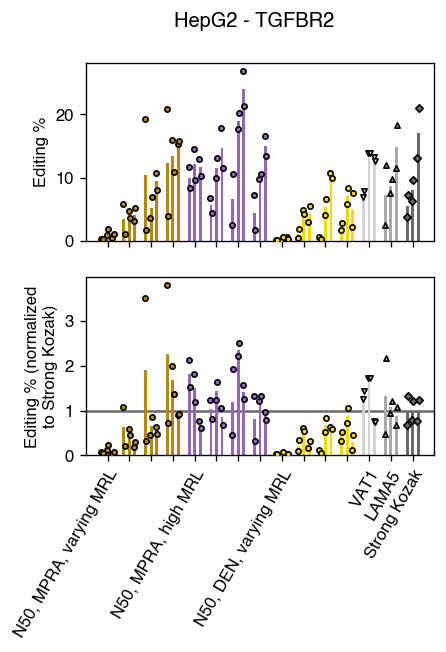

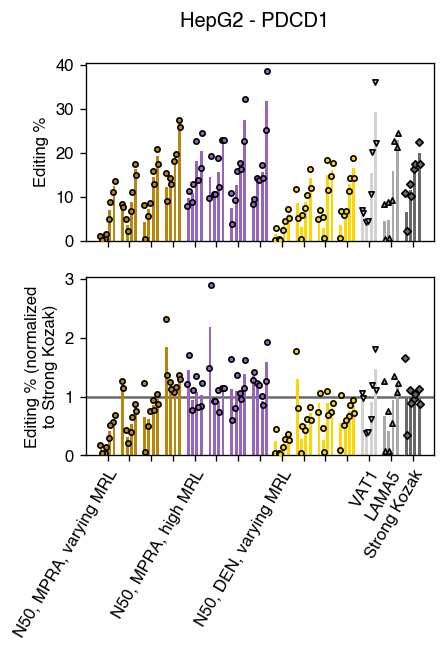

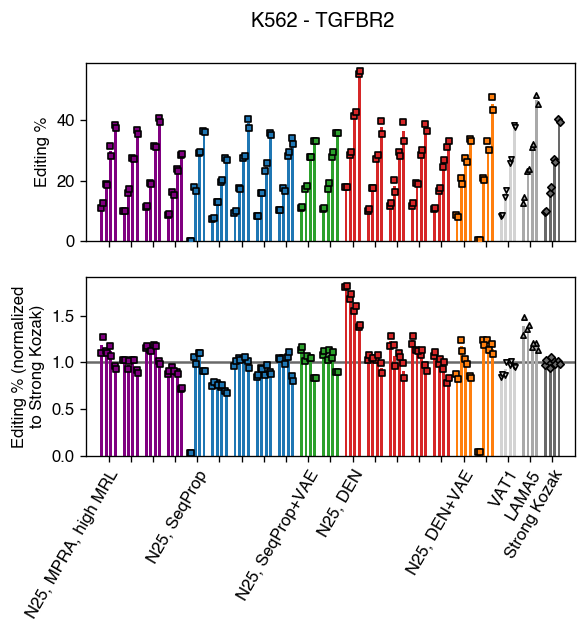

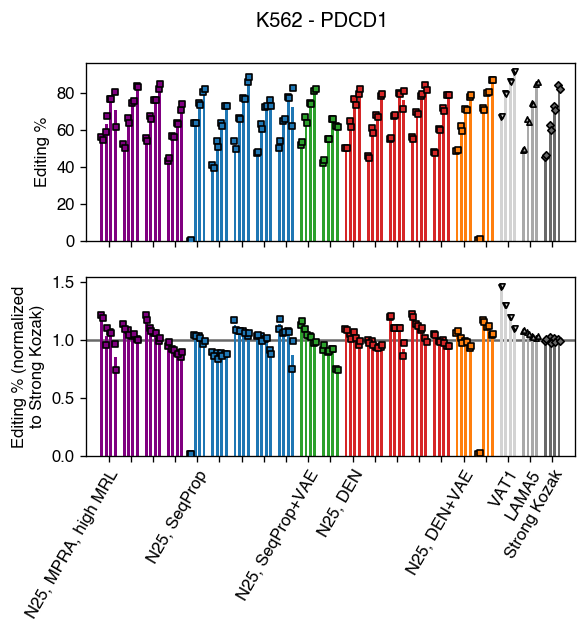

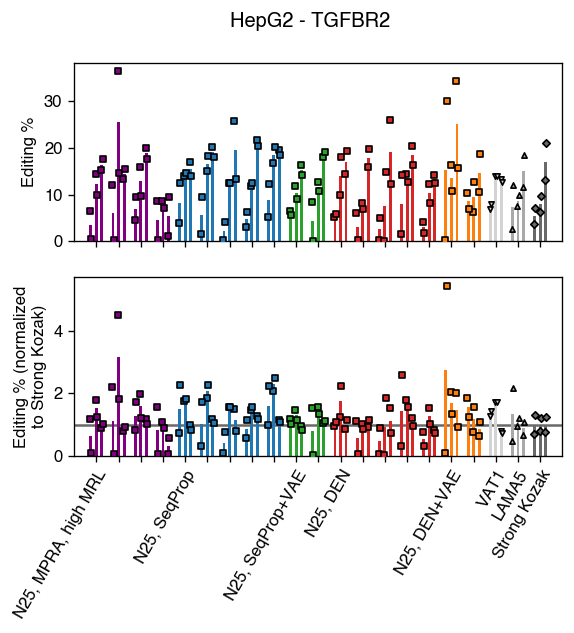

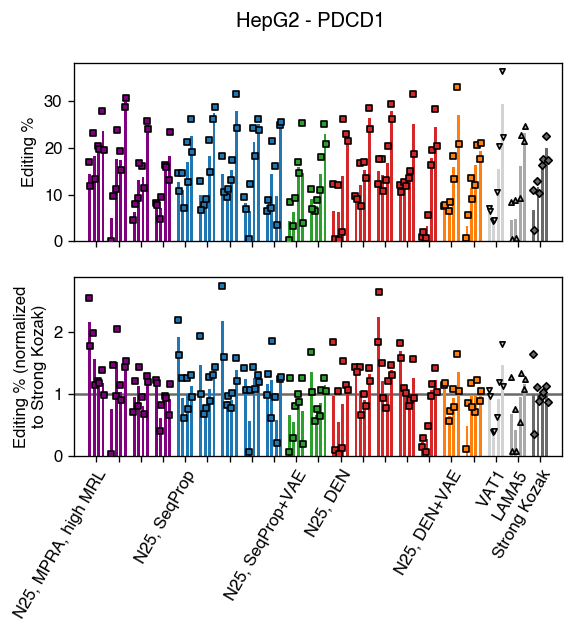

In [19]:
# Bar plots
figsize_all = {
    'n50_only_plus_varying': {'K562': {'TGFBR2': (7, 4.25), 'PDCD1': (7, 4.25)}, 'HepG2': {'TGFBR2': (7, 4.25), 'PDCD1': (7, 4.25)}},
    'n50_varying': {'K562': {'TGFBR2': (3.75, 2.9)}},
}
ylim_norm_all = {
    'n50_only': {'K562': {'TGFBR2': ([0, 1.9])}},
    'n50_only_plus_varying': {'K562': {'TGFBR2': ([0, 1.9])}},
}
for description_set, descriptions_to_plot in description_sets_to_plot.items():
    for dataset in datasets:
        for megatal in megatal_values:
            data_to_plot_all_desc = data_indel[
                (data_indel.index.get_level_values('Dataset')==dataset) &\
                (data_indel.index.get_level_values('megaTAL')==megatal)
            ]
            data_to_plot = pandas.DataFrame()
            for desc in descriptions_to_plot:
                data_to_plot_desc = data_to_plot_all_desc[data_to_plot_all_desc["5'UTR description"]==desc]
                data_to_plot = pandas.concat([data_to_plot, data_to_plot_desc], axis=0)

            # data_to_plot_mean = data_to_plot.xs('Mean', level='Replicate')
            # display(data_to_plot_mean)
            # print(data_to_plot_mean.index.get_level_values('Sequence ID').unique())

            try:
                figsize = figsize_all[description_set][dataset][megatal]
            except:
                figsize = None
            try:
                ylim_norm = ylim_norm_all[description_set][dataset][megatal]
            except:
                ylim_norm = None

            fig = plot_editing_norm(data_to_plot, figsize=figsize, ylim_norm=ylim_norm)
            fig.suptitle(f"{dataset} - {megatal}")
            fig.savefig(f'bar_{description_set}_{dataset}_{megatal}.{plt_fmt}')

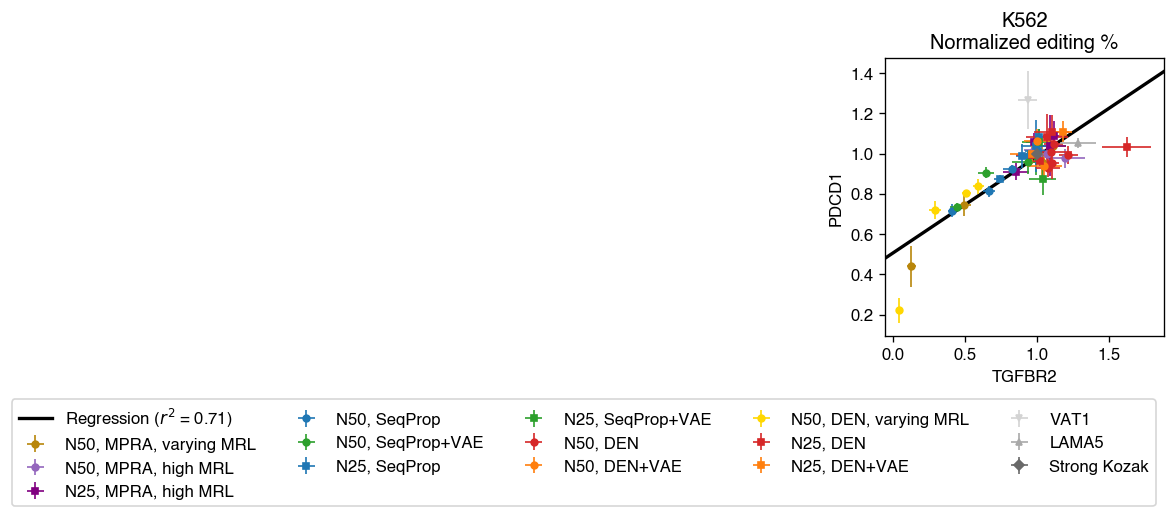

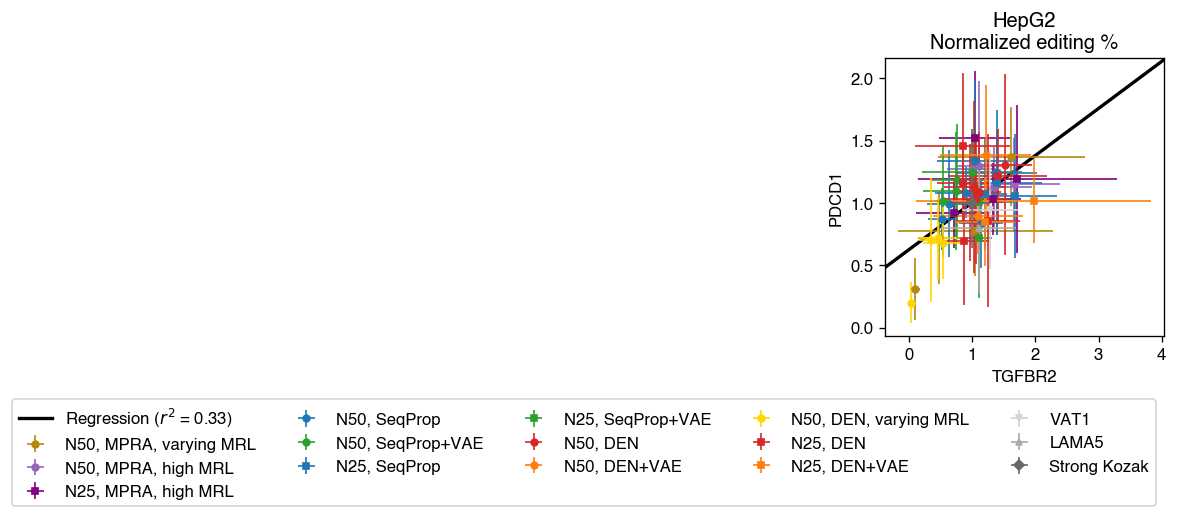

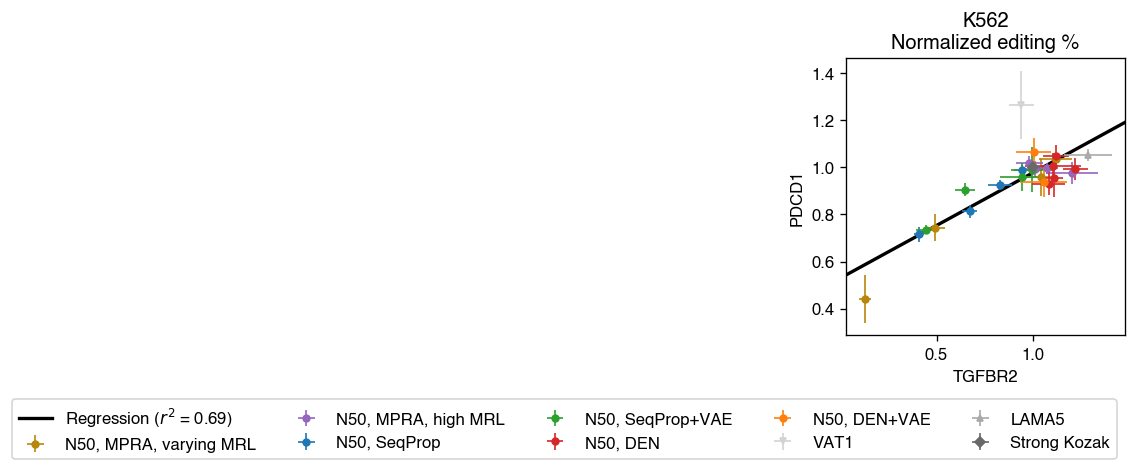

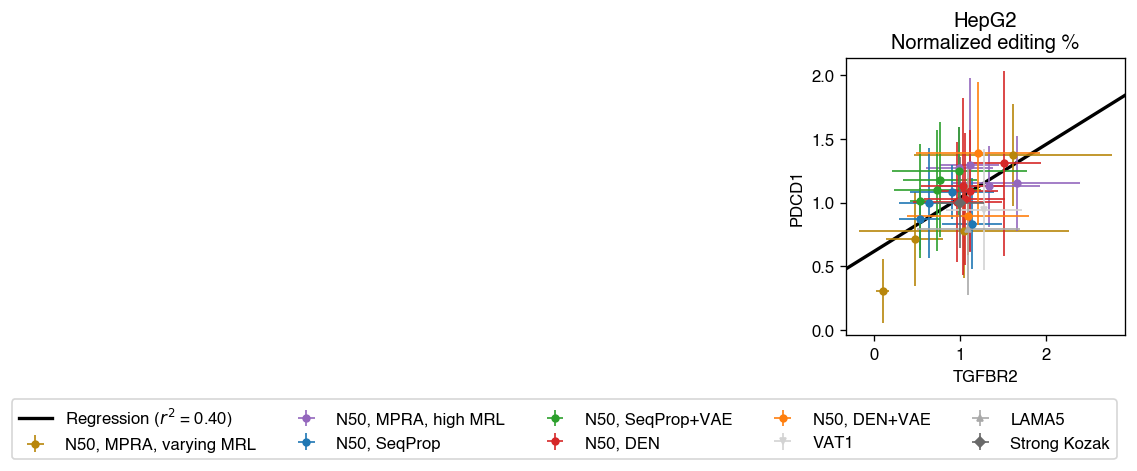

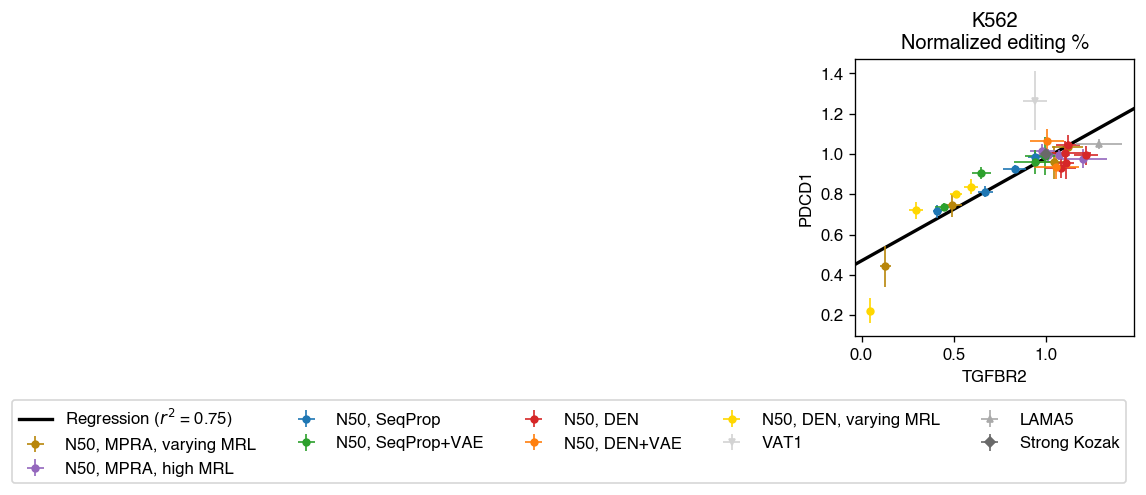

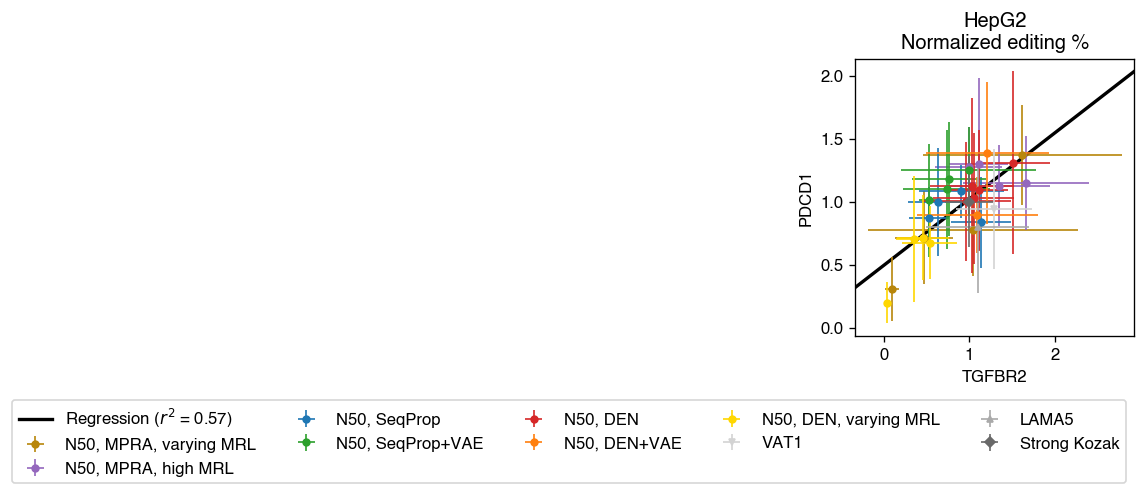

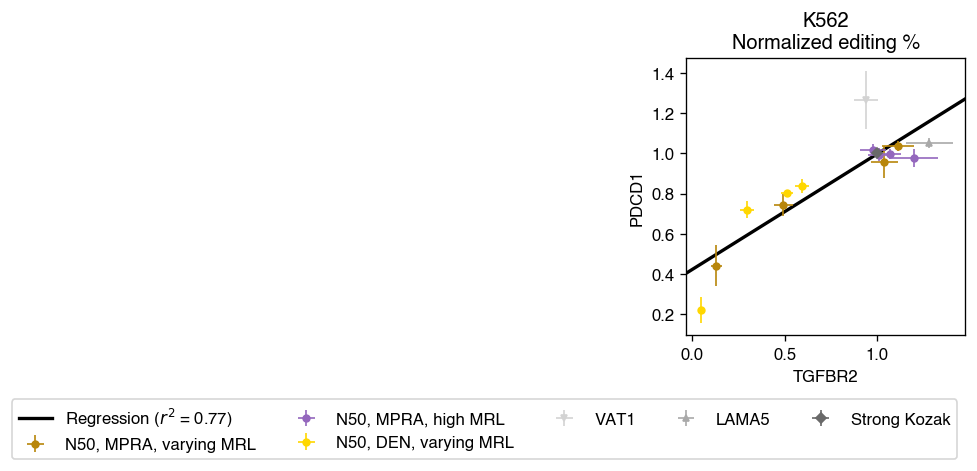

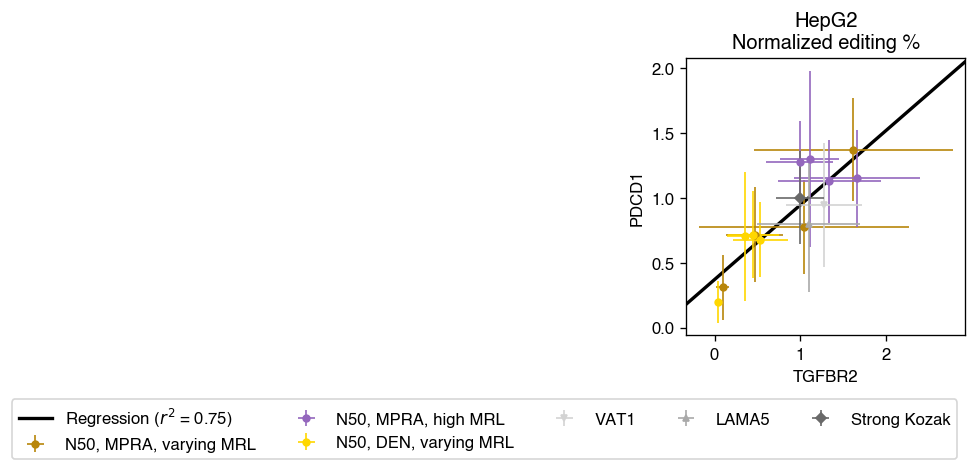

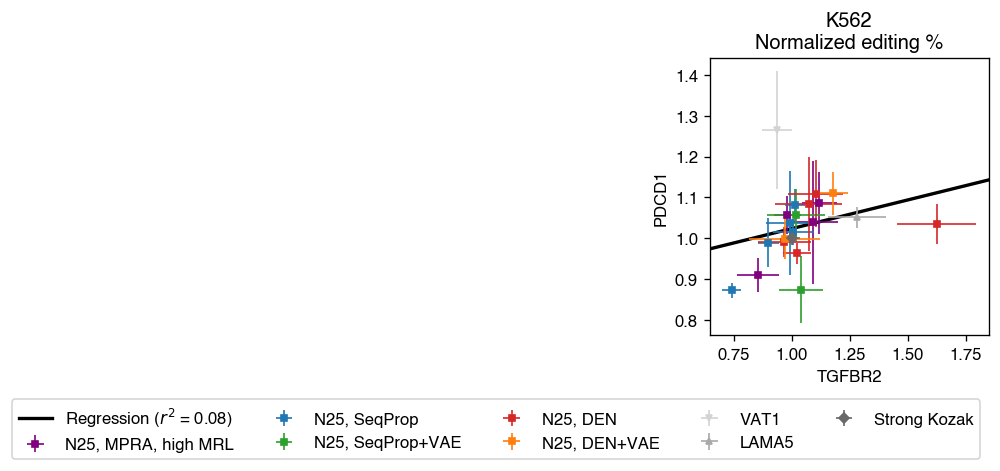

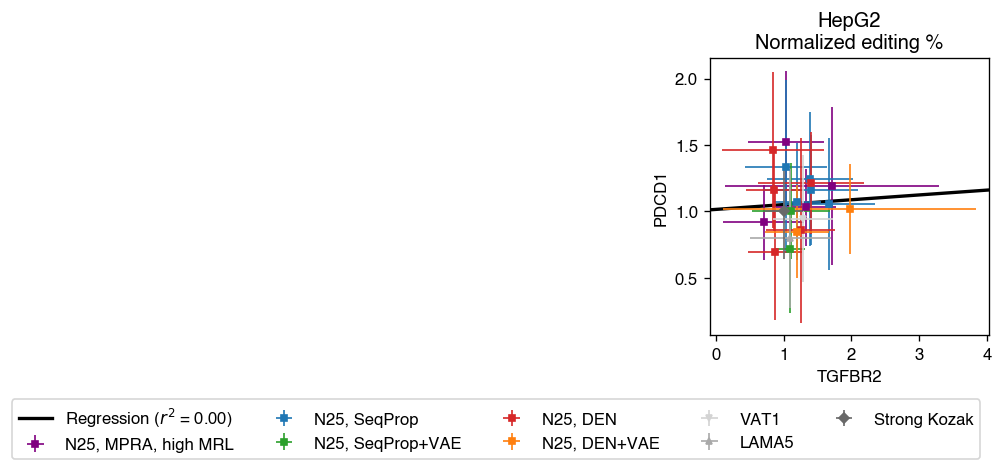

In [20]:
for description_set, descriptions_to_plot in description_sets_to_plot.items():
    # Filter by 5'UTR description
    data_to_plot = data_indel_avemrna[data_indel_avemrna["5'UTR description"].isin(descriptions_to_plot)]

    for dataset in datasets:
        fig, ax = pyplot.subplots(figsize=(3, 3))
        # Plot data by design method
        for utrtype in data_to_plot["5'UTR description"].unique():
            data_utrtype = data_to_plot[
                (data_to_plot.index.get_level_values('Dataset')==dataset) &\
                (data_to_plot["5'UTR description"]==utrtype)
            ]
            ax.errorbar(
                data_utrtype.loc[(dataset, 'TGFBR2'), 'Mean normalized indel %'],
                data_utrtype.loc[(dataset, 'PDCD1'), 'Mean normalized indel %'],
                xerr=data_utrtype.loc[(dataset, 'TGFBR2'), 'Std normalized indel %'],
                yerr=data_utrtype.loc[(dataset, 'PDCD1'), 'Std normalized indel %'],
                linestyle='',
                # marker='o',
                marker=seq_markers_dict[utrtype],
                color=seq_colors_dict[utrtype],
                linewidth=1,
                markersize=4,
                label=utrtype,
            )
        # Plot linear regression line
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
            data_to_plot.loc[(dataset, 'TGFBR2'), 'Mean normalized indel %'],
            data_to_plot.loc[(dataset, 'PDCD1'), 'Mean normalized indel %'],
        )
        ax.axline(
            (1, intercept + slope*1),
            slope=slope,
            color='k',
            linewidth=2.,
            label=f'Regression ($r^2$ = {r_value**2:.2f})',
            zorder=-1,
        )

        ax.set_xlabel('TGFBR2')
        ax.set_ylabel('PDCD1')
        ax.set_title(f"{dataset}\nNormalized editing %")
        # ax.set_xlim(0, 1)
        # ax.set_ylim(0, 1)
        # leg = ax.legend(bbox_to_anchor=(1.05, 1.04))
        leg = ax.legend(bbox_to_anchor=(1.0, -0.2), ncol=5)

        fig.savefig(f'{description_set} - {dataset} - TGFBR2_vs_PDCD1_scatter.{plt_fmt}', dpi=200, bbox_inches='tight')

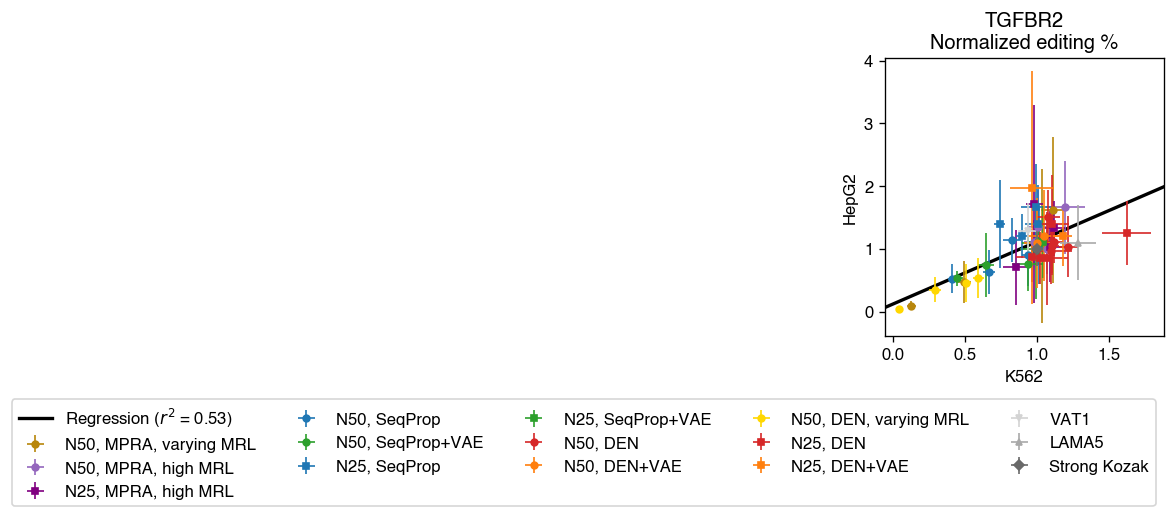

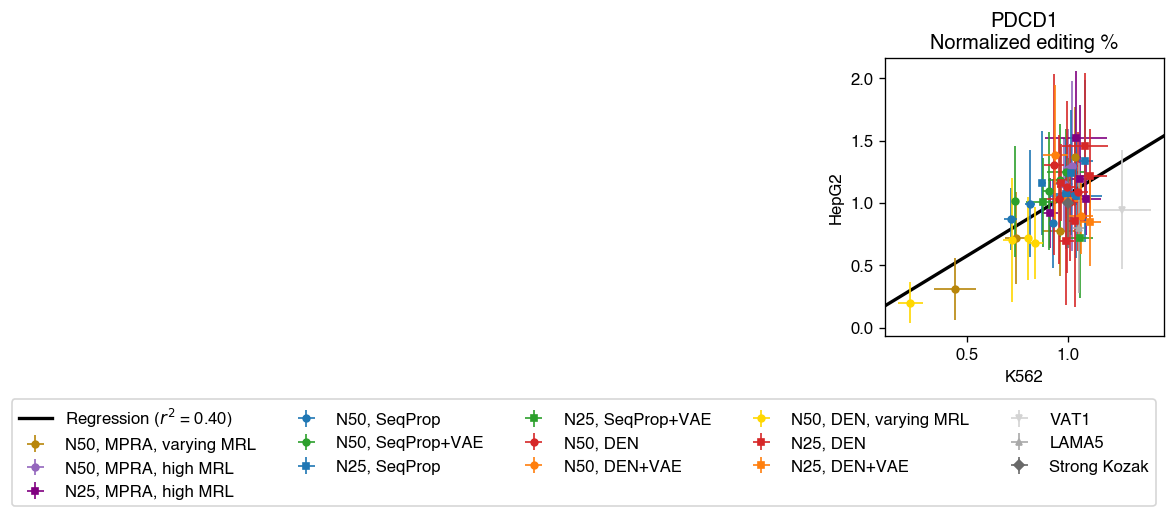

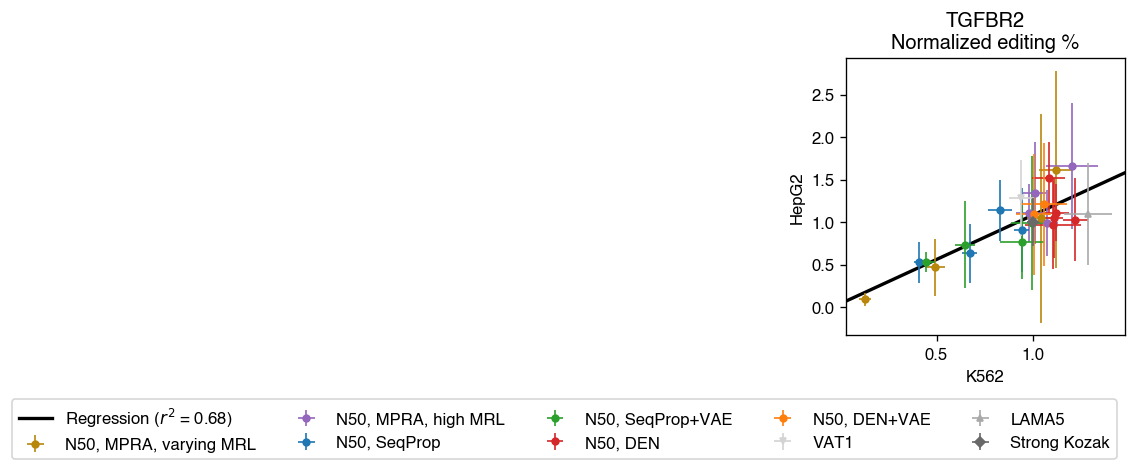

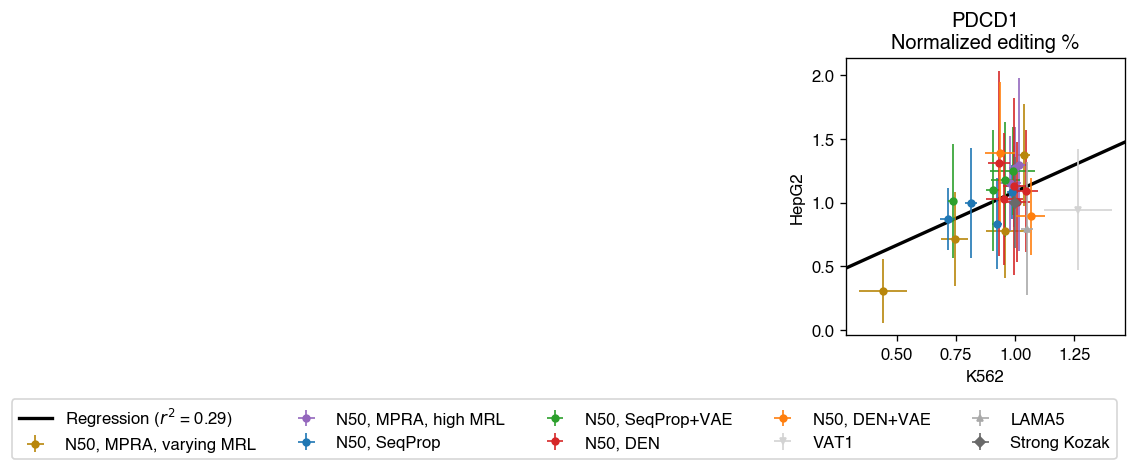

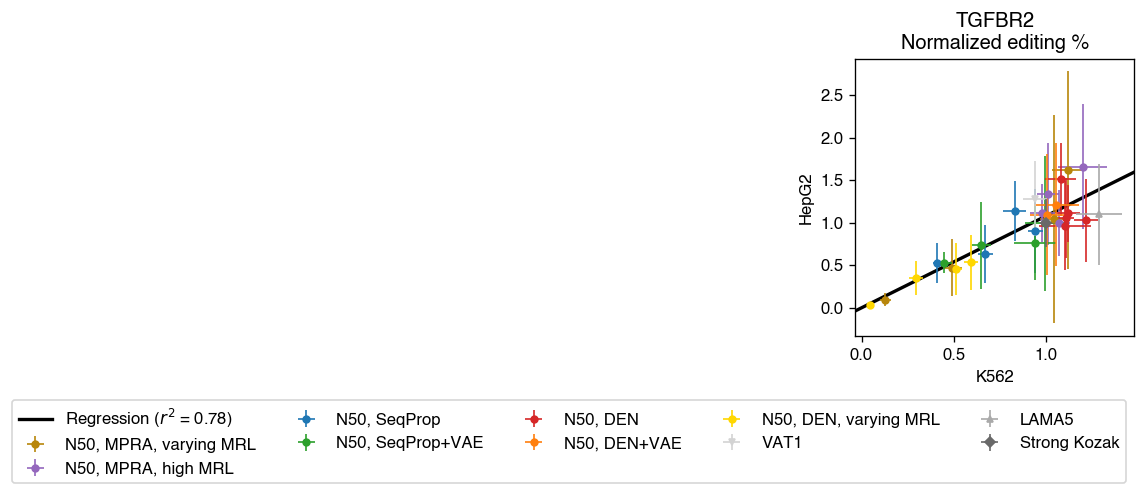

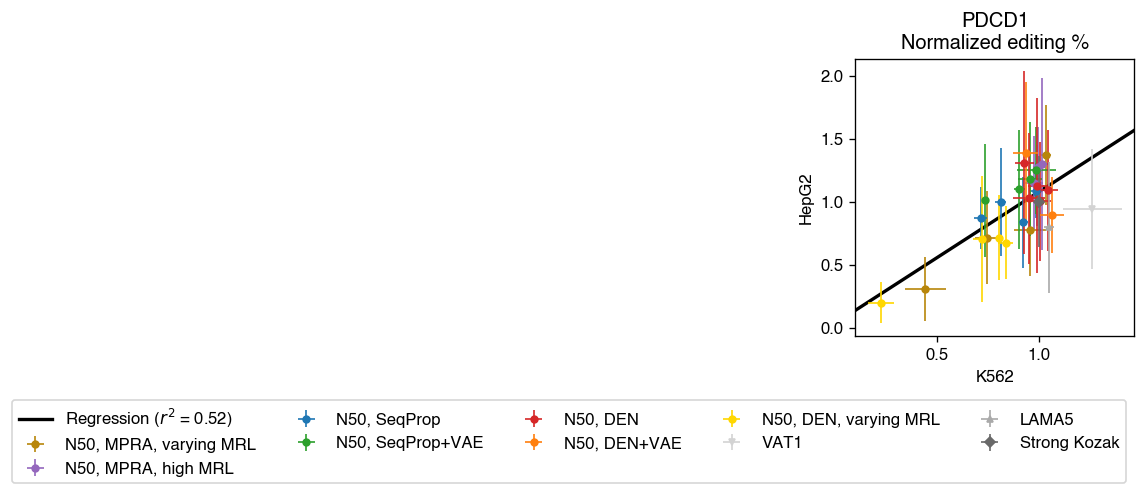

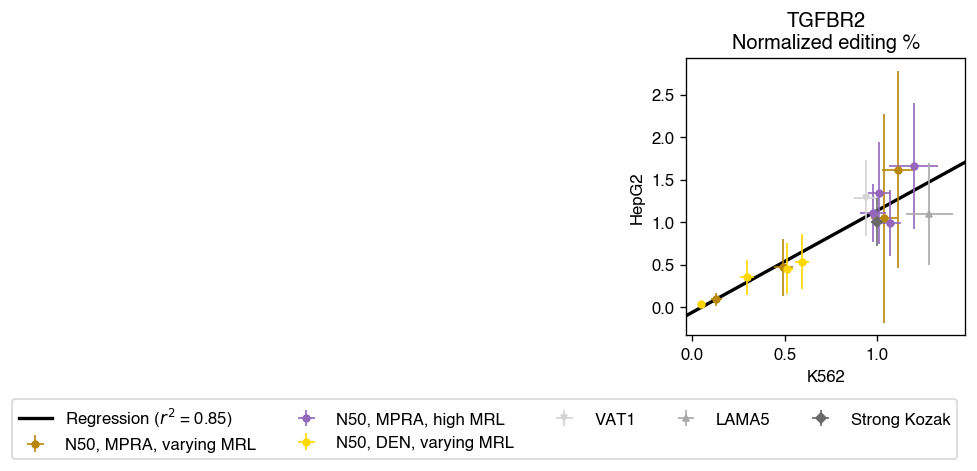

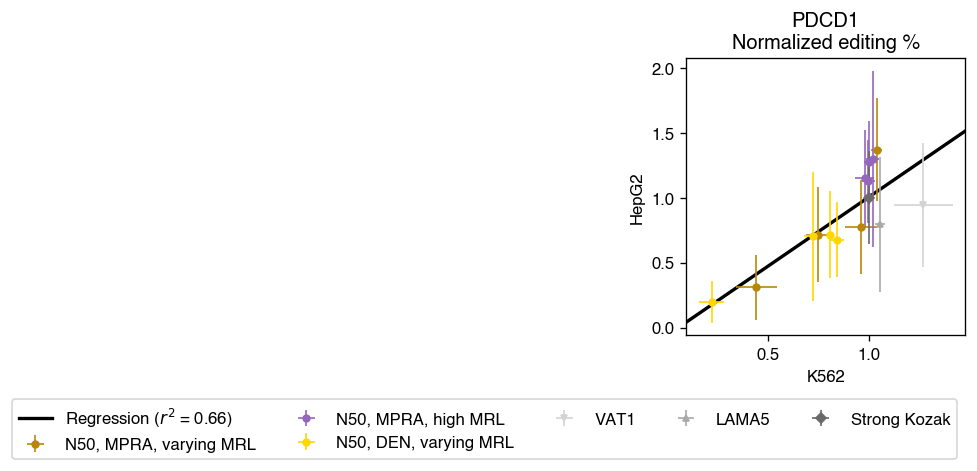

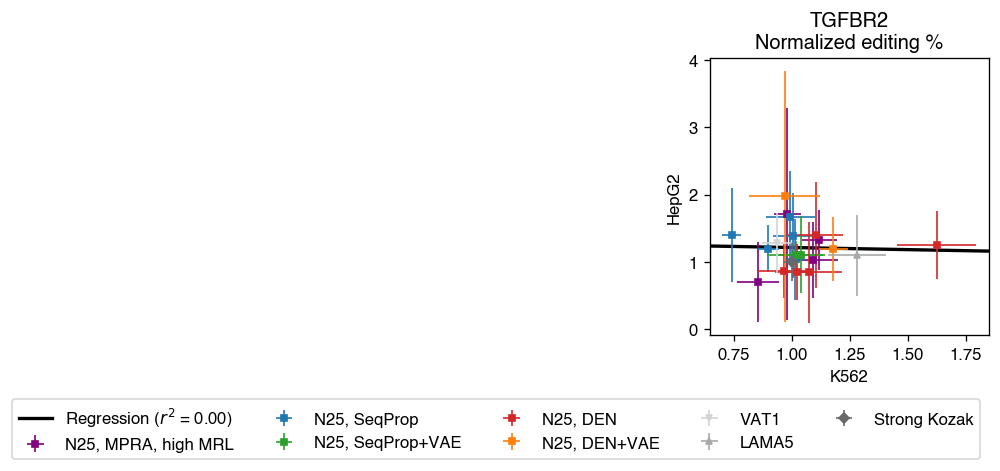

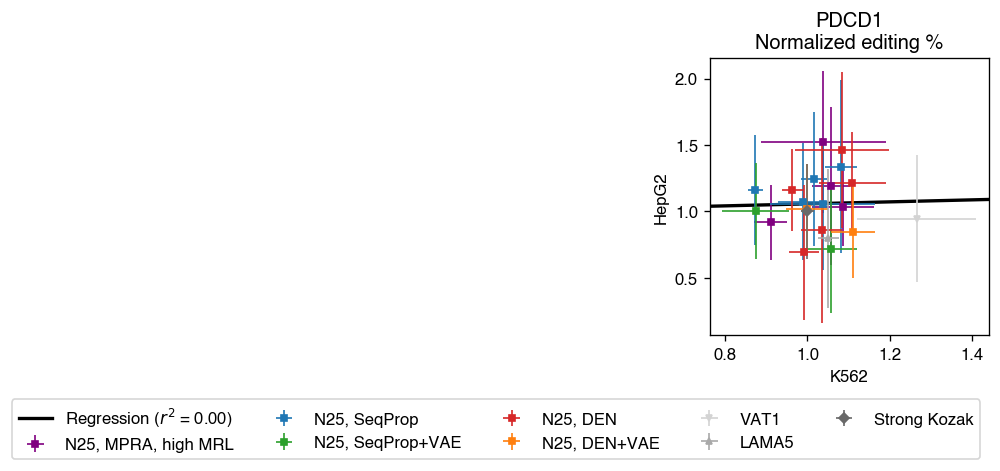

In [21]:
for description_set, descriptions_to_plot in description_sets_to_plot.items():
    # Filter by 5'UTR description
    data_to_plot = data_indel_avemrna[data_indel_avemrna["5'UTR description"].isin(descriptions_to_plot)]

    for megatal in megatal_values:
        fig, ax = pyplot.subplots(figsize=(3, 3))
        # Plot data by design method
        for utrtype in data_to_plot["5'UTR description"].unique():
            data_utrtype = data_to_plot[
                (data_to_plot.index.get_level_values('megaTAL')==megatal) &\
                (data_to_plot["5'UTR description"]==utrtype)
            ]
            ax.errorbar(
                data_utrtype.loc[(datasets[0], megatal), 'Mean normalized indel %'],
                data_utrtype.loc[(datasets[1], megatal), 'Mean normalized indel %'],
                xerr=data_utrtype.loc[(datasets[0], megatal), 'Std normalized indel %'],
                yerr=data_utrtype.loc[(datasets[1], megatal), 'Std normalized indel %'],
                linestyle='',
                # marker='o',
                marker=seq_markers_dict[utrtype],
                color=seq_colors_dict[utrtype],
                linewidth=1,
                markersize=4,
                label=utrtype,
            )
        # Plot linear regression line
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
            data_to_plot.loc[(datasets[0], megatal), 'Mean normalized indel %'],
            data_to_plot.loc[(datasets[1], megatal), 'Mean normalized indel %'],
        )
        ax.axline(
            (1, intercept + slope*1),
            slope=slope,
            color='k',
            linewidth=2.,
            label=f'Regression ($r^2$ = {r_value**2:.2f})',
            zorder=-1,
        )

        ax.set_xlabel(datasets[0])
        ax.set_ylabel(datasets[1])
        ax.set_title(f"{megatal}\nNormalized editing %")
        # ax.set_xlim(0, 1)
        # ax.set_ylim(0, 1)
        # leg = ax.legend(bbox_to_anchor=(1.05, 1.04))
        leg = ax.legend(bbox_to_anchor=(1.0, -0.2), ncol=5)

        fig.savefig(f'{description_set} - {megatal} - {datasets[0]} vs {datasets[1]} scatter.{plt_fmt}', dpi=200, bbox_inches='tight')

In [22]:
def plot_norm_editing_vs_prediction(
        data_to_plot,
        prediction_cols,
        seq_lengths=None,
        xlim_values=None,
        ylim_values=None,
        legend=True,
    ):
    fig, axes = pyplot.subplots(
        len(megatal_values),
        len(prediction_cols),
        figsize=(3.25*len(prediction_cols), 3.25*len(megatal_values)),
        squeeze=False,
    )

    for megatal_idx, megatal in enumerate(megatal_values):
        for prediction_idx, prediction_col in enumerate(prediction_cols):
            ax = axes[megatal_idx, prediction_idx]

            # Filter data to plot
            data_panel = data_to_plot[(data_to_plot.index.get_level_values('megaTAL')==megatal)]
            if seq_lengths is not None:
                seq_length = seq_lengths[prediction_idx]
                if seq_length is not None:
                    data_panel = data_panel[data_panel["5'UTR sequence"].str.len()==seq_length]

            # Plot
            for utrtype in data_panel["5'UTR description"].unique():
                data_utrtype = data_panel[data_panel["5'UTR description"]==utrtype]
                ax.errorbar(
                    data_utrtype[prediction_col].values,
                    data_utrtype['Mean normalized indel %'].values,
                    yerr=data_utrtype['Std normalized indel %'].values,
                    linestyle='',
                    # marker='o',
                    marker=seq_markers_dict[utrtype],
                    color=seq_colors_dict[utrtype],
                    linewidth=1,
                    markersize=5,
                    label=utrtype,
                )

            # Adjust axis
            if xlim_values is not None:
                ax.set_xlim(xlim_values[prediction_idx])
            if ylim_values is not None:
                ax.set_ylim(ylim_values[megatal_idx])
                
            # Plot linear regression line
            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
                data_panel[prediction_col].values,
                data_panel['Mean normalized indel %'].values,
            )
            xlim = ax.get_xlim()
            xlim_center = numpy.mean(xlim)
            ax.axline(
                (xlim_center, intercept + slope*xlim_center),
                slope=slope,
                color='k',
                linewidth=2.,
                # label=f'Regression ($r^2$ = {r_value**2:.2f})',
                zorder=-1,
            )
            # Write r^2
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()
            xpos = xlim[0] + (xlim[1] - xlim[0])*0.97
            ypos = ylim[0] + (ylim[1] - ylim[0])*0.1
            # ypos = intercept + xpos*slope
            ax.text(xpos, ypos, f"$r^2$ = {r_value**2:.2f}", {'ha': 'right', 'va': 'top', 'color': 'k'})
            
            if legend:
                if megatal_idx==0 and prediction_idx==(len(prediction_cols) - 1):
                    ax.legend(bbox_to_anchor=(1.05, 1.04))
            
            if megatal_idx==(len(megatal_values) - 1):
                ax.set_xlabel(prediction_col)
            else:
                ax.set_xticklabels([])
            if prediction_idx==0:
                ax.set_ylabel(f"{megatal} Editing %\n(normalized to {norm_seq_desc})")
            else:
                ax.set_yticklabels([])

    return fig, axes

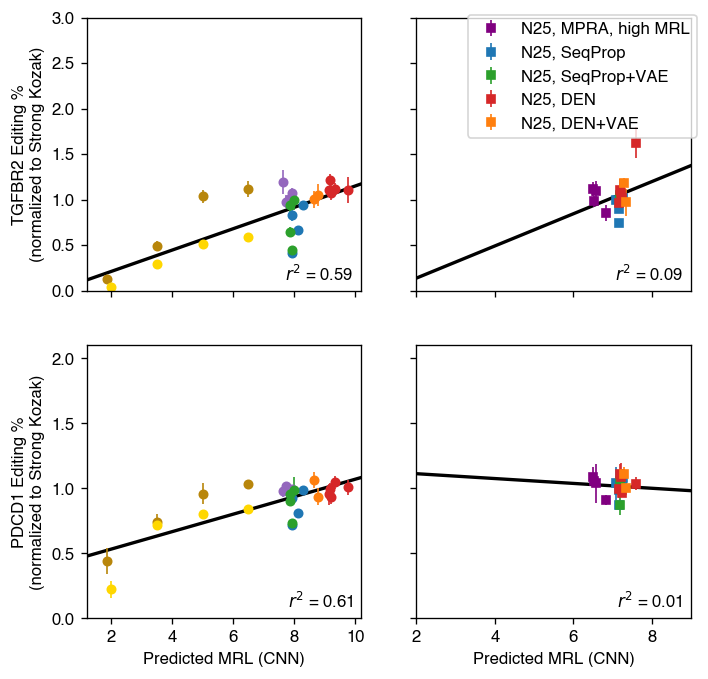

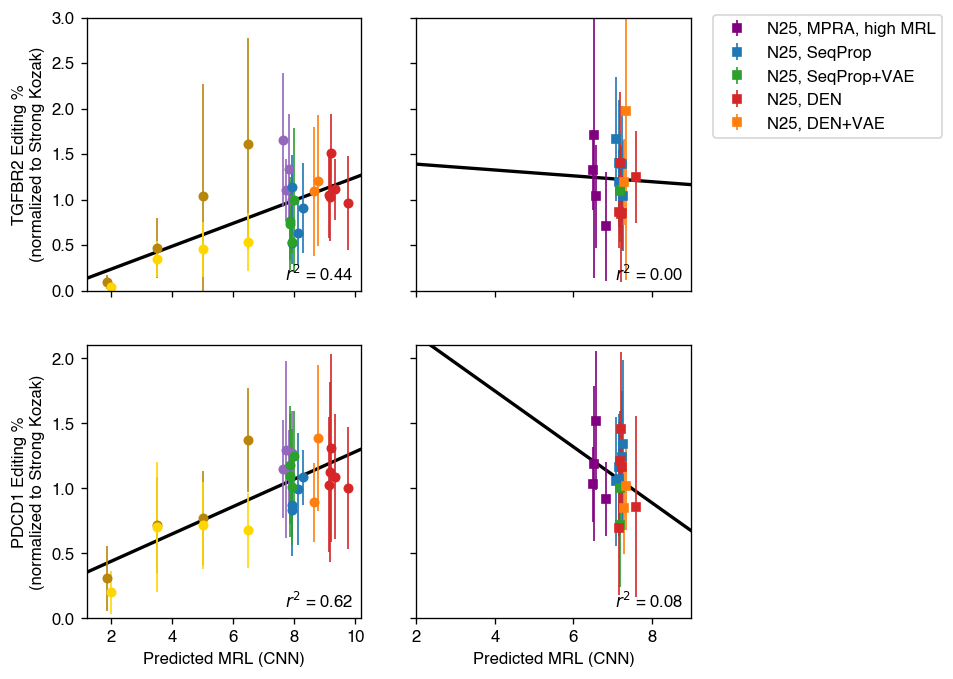

In [23]:
# Plot predicted MRL vs. editing efficiency
# Cols: CNN (optimus, 50bp seqs), CNN (vgg, 25bp seqs)
# Rows: MegaTALs
description_set = 'all'
prediction_cols = ['Predicted MRL (CNN)', 'Predicted MRL (CNN)']
seq_lengths = [72, 25]
xlim_values = [(1.2, 10.2), (2, 9)]
# ylim_values = [(0, 1.85), (0, 1.5)]
ylim_values = [(0, 3), (0, 2.1)]

for dataset in datasets:
    data_to_plot = data_indel_avemrna[
        (data_indel_avemrna["5'UTR description"].isin(description_sets_to_plot[description_set])) &\
        (data_indel_avemrna.index.get_level_values('Dataset')==dataset)
    ]

    fig, axes = plot_norm_editing_vs_prediction(
        data_to_plot,
        prediction_cols,
        seq_lengths,
        xlim_values,
        ylim_values,
        legend=True,
    )

    fig.savefig(f'{description_set} - {dataset}_editing_norm_vs_predictions_all.{plt_fmt}', dpi=200, bbox_inches='tight')

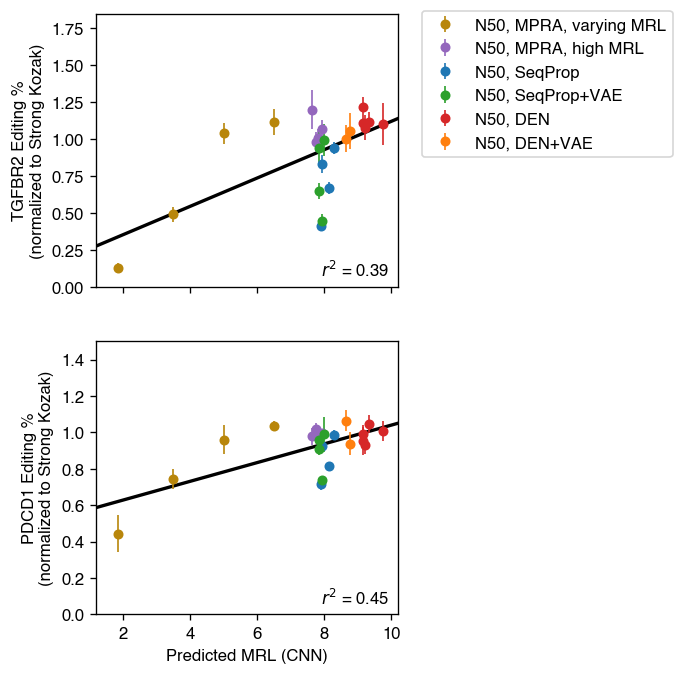

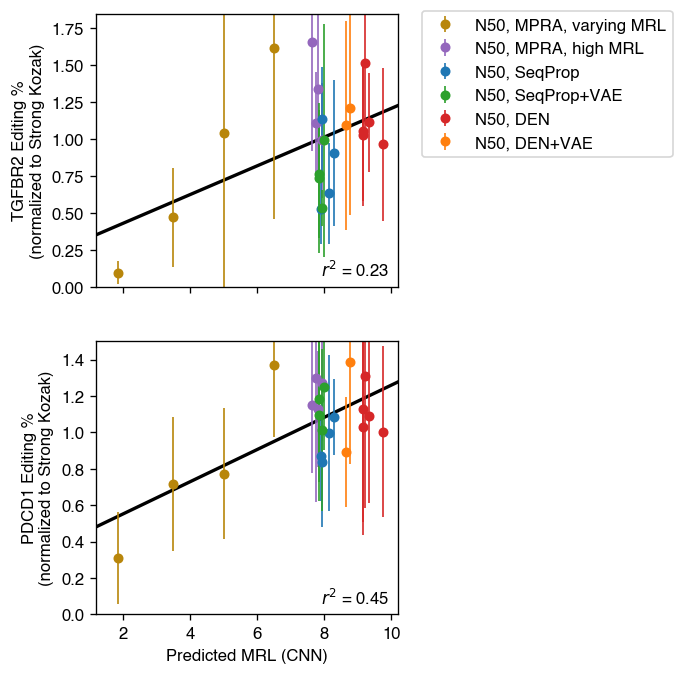

In [24]:
# Plot predicted MRL vs. editing efficiency
# Rows: MegaTALs
description_set = 'n50_only'
prediction_cols = ['Predicted MRL (CNN)']
seq_lengths = [72]
xlim_values = [(1.2, 10.2)]
ylim_values = [(0, 1.85), (0, 1.5)]

for dataset in datasets:
    data_to_plot = data_indel_avemrna[
        (data_indel_avemrna["5'UTR description"].isin(description_sets_to_plot[description_set])) &\
        (data_indel_avemrna.index.get_level_values('Dataset')==dataset)
    ]

    fig, axes = plot_norm_editing_vs_prediction(
        data_to_plot,
        prediction_cols,
        seq_lengths,
        xlim_values,
        ylim_values,
        legend=True,
    )

    fig.savefig(f'{description_set} - {dataset}_editing_norm_vs_predictions_50nt_only.{plt_fmt}', dpi=200, bbox_inches='tight')

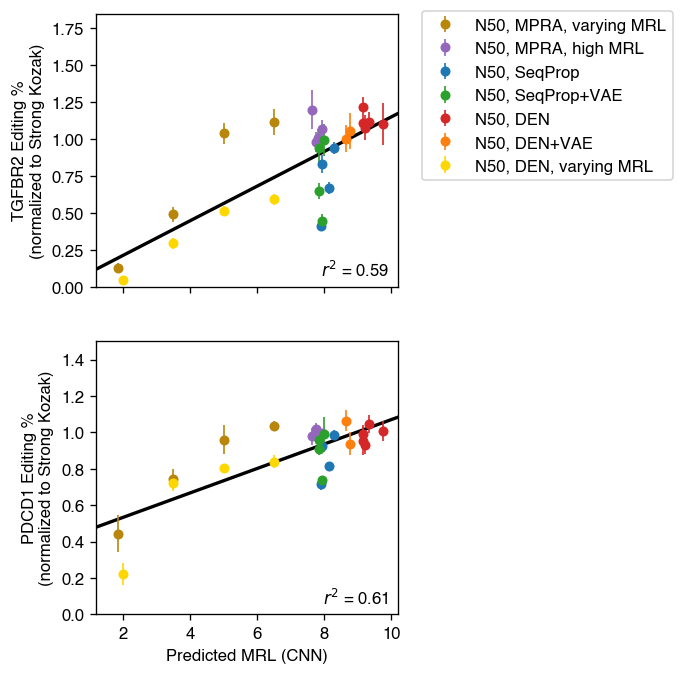

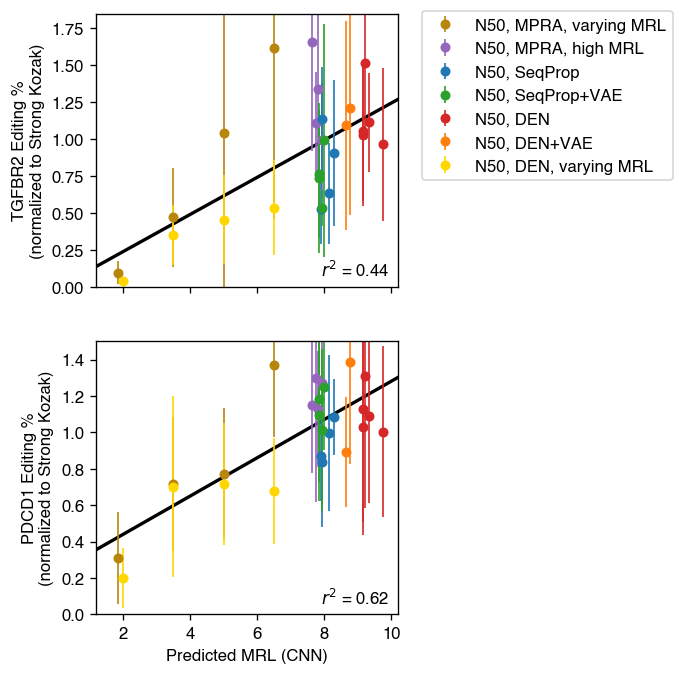

In [25]:
# Plot predicted MRL vs. editing efficiency
# Rows: MegaTALs
description_set = 'n50_only_plus_varying'
prediction_cols = ['Predicted MRL (CNN)']
seq_lengths = [72, 72]
xlim_values = [(1.2, 10.2)]
ylim_values = [(0, 1.85), (0, 1.5)]

for dataset in datasets:
    data_to_plot = data_indel_avemrna[
        (data_indel_avemrna["5'UTR description"].isin(description_sets_to_plot[description_set])) &\
        (data_indel_avemrna.index.get_level_values('Dataset')==dataset)
    ]

    fig, axes = plot_norm_editing_vs_prediction(
        data_to_plot,
        prediction_cols,
        seq_lengths,
        xlim_values,
        ylim_values,
        legend=True,
    )

    fig.savefig(f'{description_set} - {dataset}_editing_norm_vs_predictions_50nt_only.{plt_fmt}', dpi=200, bbox_inches='tight')

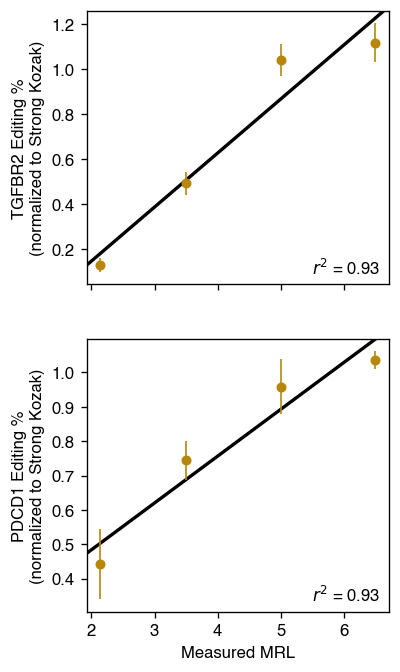

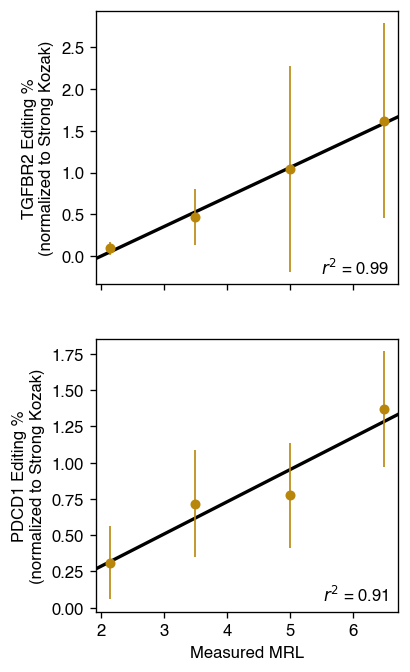

In [26]:
# Plot predicted MRL vs. editing efficiency for varying MRL controls
prediction_cols = ['Measured MRL']

for dataset in datasets:
    data_to_plot = data_indel_avemrna[
        (data_indel_avemrna["5'UTR description"].isin(
            [
                'N50, MPRA, varying MRL',
            ],
        )) &\
        (data_indel_avemrna.index.get_level_values('Dataset')==dataset)
    ]

    fig, axes = plot_norm_editing_vs_prediction(
        data_to_plot,
        prediction_cols,
        legend=False,
    )

    fig.savefig(f'{dataset}_editing_norm_vs_predictions_varying_controls.{plt_fmt}', dpi=200, bbox_inches='tight')

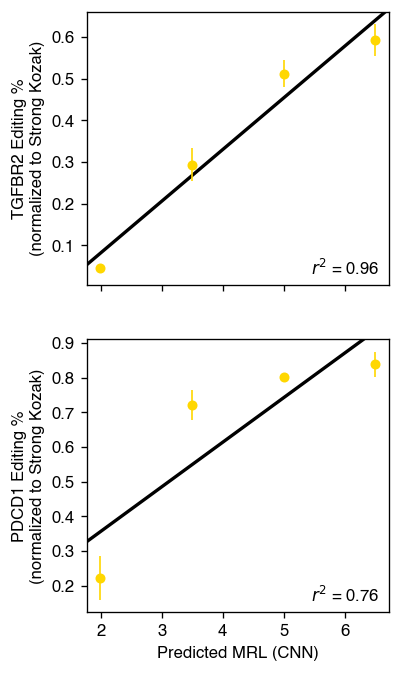

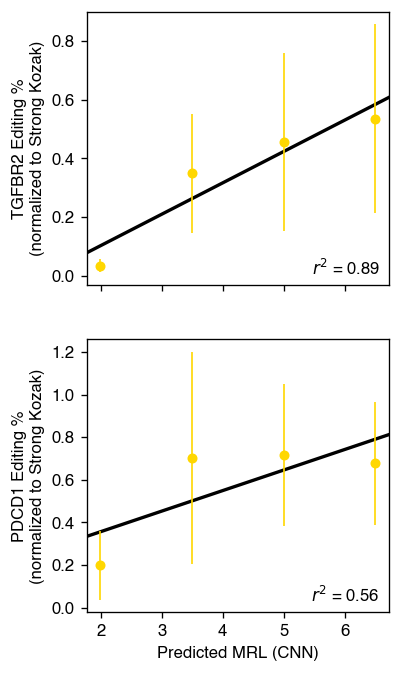

In [27]:
# Plot predicted MRL vs. editing efficiency for varying MRL designs
prediction_cols = ['Predicted MRL (CNN)']
xlim_values = [(1.2, 8.2)]
ylim_values = [(0, 1.85), (0, 1.85)]

for dataset in datasets:
    data_to_plot = data_indel_avemrna[
        (data_indel_avemrna["5'UTR description"].isin(
            [
                'N50, DEN, varying MRL',
            ],
        )) &\
        (data_indel_avemrna.index.get_level_values('Dataset')==dataset)
    ]

    fig, axes = plot_norm_editing_vs_prediction(
        data_to_plot,
        prediction_cols,
        legend=False,
    )

    fig.savefig(f'{dataset}_editing_norm_vs_predictions_varying_designed.{plt_fmt}', dpi=200, bbox_inches='tight')

In [28]:
def plot_editing_vs_mrna(
        data_to_plot,
    ):
    megatal_values_to_plot = data_to_plot.index.get_level_values('megaTAL').unique().sort_values(ascending=False)
    fig, axes = pyplot.subplots(
        1,
        len(megatal_values_to_plot),
        figsize=(3.25*len(megatal_values_to_plot), 3),
        squeeze=False,
    )

    for megatal_idx, megatal in enumerate(megatal_values_to_plot):
        ax = axes[0, megatal_idx]

        # Filter by megatal
        data_to_plot_megatal = data_to_plot[data_to_plot.index.get_level_values('megaTAL')==megatal]

        for seq_id in data_to_plot_megatal.index.get_level_values('Sequence ID').unique():

            # Only data from current sequence
            data_to_plot_seq = data_to_plot_megatal[data_to_plot_megatal.index.get_level_values('Sequence ID')==seq_id]

            # Separate data from replicates and mean
            data_to_plot_seq_reps = data_to_plot_seq[
                data_to_plot_seq.index.get_level_values('Replicate').astype(str).str.isnumeric()
            ]
            data_to_plot_seq_mean = data_to_plot_seq[
                data_to_plot_seq.index.get_level_values('Replicate')=='Mean'
            ]

            # Plot mean line
            seq_description = data_to_plot_seq_mean["5'UTR description"].values[0]
            ax.plot(
                data_to_plot_seq_mean.index.get_level_values('mRNA pmol'),
                data_to_plot_seq_mean["Indel %"]*100,
                # marker=seq_markers_dict[seq_description],
                color=seq_colors_dict[seq_description],
            )

            # Plot vertical lines with circles on each replicate, for each mRNA concentration
            for idx, (index, row) in enumerate(data_to_plot_seq_mean.iterrows()):
                data_seq_mrna = data_to_plot_seq_reps.loc[index[:-1]]
                if idx==0:
                    label = f"ID {seq_id} - {seq_description}"
                else:
                    label = None
                ax.plot(
                    [index[2]]*len(data_seq_mrna["Indel %"]),
                    data_seq_mrna["Indel %"]*100,
                    marker=seq_markers_dict[seq_description],
                    color=seq_colors_dict[seq_description],
                    markersize=5,
                    label=label,
                )

        if megatal_idx==(len(megatal_values_to_plot) - 1):
            ax.legend(bbox_to_anchor=(1.05, 1.04))
                
        ax.set_xlabel('mRNA (pmol)')
        if megatal_idx==0:
            ax.set_ylabel(f"Editing %")
        ax.set_title(megatal)
        # ax.set_xticks(data_to_plot_megatal.index.get_level_values('mRNA pmol').unique().sort_values())
        # ax.set_xlim(-0.05, 2.1)

    return fig, axes

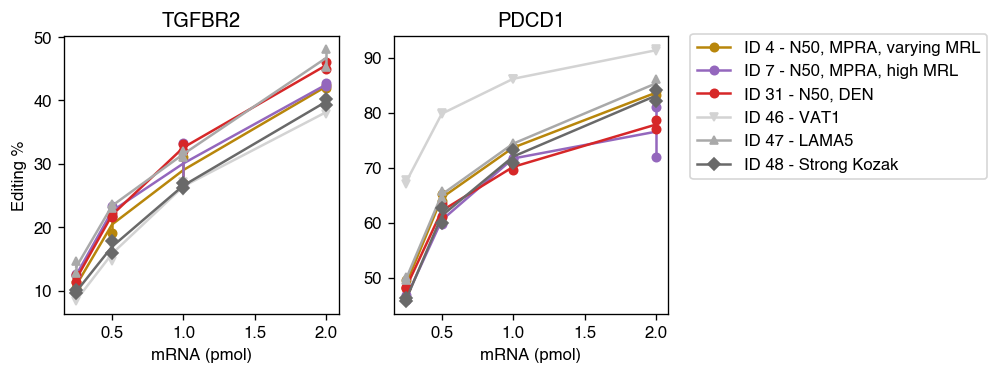

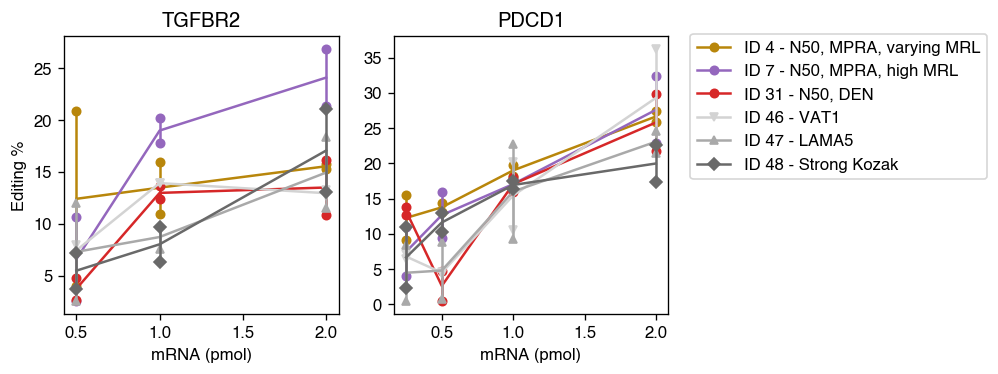

In [29]:
# Plot mRNA concentration vs. absolute editing %
# Columns: megatals

for dataset in datasets:
    data_to_plot = data_indel[data_indel.index.get_level_values('Dataset')==dataset]
    # data_to_plot = data_to_plot[data_to_plot["5'UTR description"].isin([
    #     # 'Varied MRLs from 50bp library',
    #     # '50bp UTR with varied MRLs designed with DEN',
    #     # 'High MRLs from 50bp library',
    #     # '50bp UTR designed with SeqProp',
    #     # '50bp UTR designed with SeqProp + VAE',
    #     # '50bp UTR designed with DEN',
    #     # '50bp UTR designed with DEN + VAE',
    #     # 'High MRLs from 25bp library',
    #     # '25bp UTR designed with SeqProp',
    #     # '25bp UTR designed with SeqProp + VAE',
    #     # '25bp UTR designed with DEN',
    #     # '25bp UTR designed with DEN + VAE',
    #     'VAT1',
    #     'LAMA5',
    #     'Strong Kozak',
    # ])]
    data_to_plot = data_to_plot[data_to_plot.index.get_level_values('Sequence ID').isin([4, 7, 31, 46, 47, 48])]

    fig, axes = plot_editing_vs_mrna(data_to_plot)

    fig.savefig(f'{dataset}_editing_vs_mrna_best_n50.{plt_fmt}', dpi=200, bbox_inches='tight')

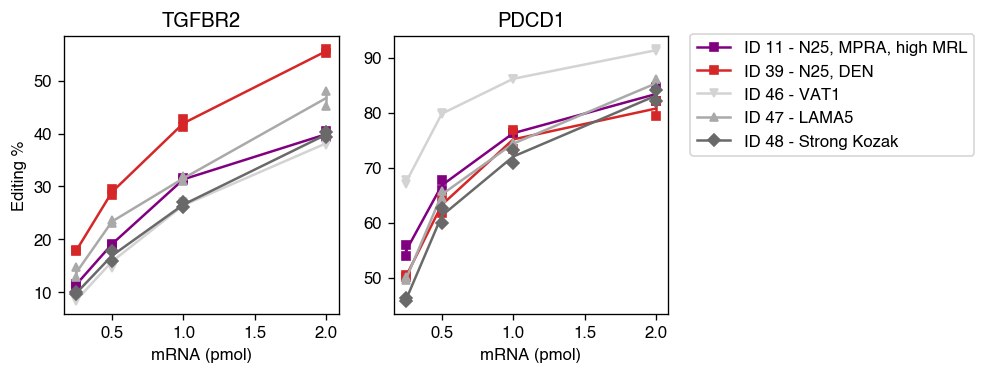

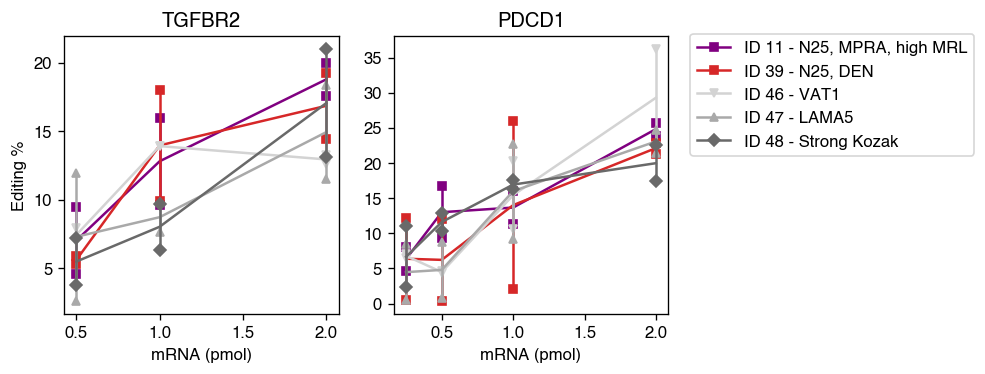

In [30]:
# Plot mRNA concentration vs. absolute editing %
# Columns: megatals

for dataset in datasets:
    data_to_plot = data_indel[data_indel.index.get_level_values('Dataset')==dataset]
    # data_to_plot = data_to_plot[data_to_plot["5'UTR description"].isin([
    #     # 'Varied MRLs from 50bp library',
    #     # '50bp UTR with varied MRLs designed with DEN',
    #     # 'High MRLs from 50bp library',
    #     # '50bp UTR designed with SeqProp',
    #     # '50bp UTR designed with SeqProp + VAE',
    #     # '50bp UTR designed with DEN',
    #     # '50bp UTR designed with DEN + VAE',
    #     # 'High MRLs from 25bp library',
    #     # '25bp UTR designed with SeqProp',
    #     # '25bp UTR designed with SeqProp + VAE',
    #     # '25bp UTR designed with DEN',
    #     # '25bp UTR designed with DEN + VAE',
    #     'VAT1',
    #     'LAMA5',
    #     'Strong Kozak',
    # ])]
    data_to_plot = data_to_plot[data_to_plot.index.get_level_values('Sequence ID').isin([11, 39, 46, 47, 48])]

    fig, axes = plot_editing_vs_mrna(data_to_plot)

    fig.savefig(f'{dataset}_editing_vs_mrna_best_n25.{plt_fmt}', dpi=200, bbox_inches='tight')

# Plot half-life values from Saluki predictions

In [19]:
# Load table with Saluki predictions
data_seqs_half_life = pandas.read_csv('half_life_predictions.csv', index_col=['megaTAL', 'Sequence ID'])
data_seqs_half_life.rename(columns={'hl_mean': 'half_life_mean', 'hl_std': 'half_life_std'}, inplace=True)

half_life_cols = [c for c in data_seqs_half_life.columns if c[:4]=='hl_f']

data_seqs_half_life

Unnamed: 0             Description  Measured MRL  \
megaTAL Sequence ID                                                     
PDCD1   1                     0  N50, MPRA, varying MRL      2.142014   
        2                     1  N50, MPRA, varying MRL      3.497435   
        3                     2  N50, MPRA, varying MRL      5.000827   
        4                     3  N50, MPRA, varying MRL      6.495498   
        5                     4     N50, MPRA, high MRL     10.360463   
...                         ...                     ...           ...   
TGFBR2  44                   91            N25, DEN+VAE           NaN   
        45                   92            N25, DEN+VAE           NaN   
        46                   93                    VAT1           NaN   
        47                   94                   LAMA5           NaN   
        48                   95            Strong Kozak           NaN   

                     Predicted MRL  \
megaTAL Sequence ID                  
PDCD1   1                 1.869994   
        2                 3.500646   
        3                 5.002466   
        4                 6.496485   
        5                 7.823140   
...                            ...   
TGFBR2  44                7.329358   
        45                7.291570   
        46                     NaN   
        47                     NaN   
        48                     NaN   

                                                                                                                         5_utr  \
megaTAL Sequence ID                                                                                                              
PDCD1   1                                          GGGACATCGTAGAGAGTCGTACTTAAGGGATGCCACCGTTTAAAGGATATCTCGGTATGGCCTGGGTAAGCTTCC   
        2                                          GGGACATCGTAGAGAGTCGTACTTAACTCTAGAGTCAGGCATTCTGTGAAATGGACATGGGCGAAGTAGGACCTA   
        3                                          GGGACATCGTAGAGAGTCGTACTTACAGCTCCTGCCAACGCAGAAGGCACCTATGCACTCTCGGACCGCGTCTCC   
        4                                          GGGACATCGTAGAGAGTCGTACTTACCGGCAAGGGGTCCGGGGGTCTCCAACGCAGGAGCACACCGCAAGCTTAG   
        5                                          GGGACATCGTAGAGAGTCGTACTTACAAGAGTGCAAGACACGCTCAGAAGTTAACAAAGACTTAGCGACACCGTC   
...                                                                                                                        ...   
TGFBR2  44                                                                                        GGGTTCGCGAGAGAGGGAATTATACGTT   
        45                                                                                        GGGTTCACGCGAGAGGACTGCGAGGACA   
        46           GGGGCTGGATCCCGCAGCCGCGGCTCTTCCCGACGCGTTCCGCCTTCCCCAGCTGTGCACTCTCCATCCAGCTGTGCGCTCTCGTCGGGAGTCCCAGCCGCCACC   
        47                                        GGGAGACCCGCCGGGCTCCCGCCGCGCGCGCTGTCCCTGGAGCTCGGGGACGCGGCCCGGAGCCGGGAAGGCCACC   
        48                                                                                                           GGGGCCACC   

                     hl_f0_c0  hl_f0_c1  hl_f0_c2  hl_f0_c3  hl_f0_c4  \
megaTAL Sequence ID                                                     
PDCD1   1           -1.563945 -1.831079 -1.441412 -1.749237 -1.627145   
        2           -1.595079 -1.849969 -1.476217 -1.760395 -1.619472   
        3           -1.630380 -1.884301 -1.476339 -1.763783 -1.649271   
        4           -1.578577 -1.832553 -1.439570 -1.760579 -1.600679   
        5           -1.581451 -1.792970 -1.451983 -1.754141 -1.589262   
...                       ...       ...       ...       ...       ...   
TGFBR2  44          -1.412611 -2.039036 -1.292692 -1.781229 -1.520596   
        45          -1.426780 -2.039562 -1.290788 -1.786450 -1.521179   
        46          -1.506342 -1.984817 -1.362664 -1.752008 -1.450483   
        47          -1.359753 -2.040990 -1.264239 -1.756921 -1.413297   
        4

In [20]:
# Combine half life with indel data
data_indel_half_life = data_indel_avemrna.copy()
# Reset index and asign half life columns by sequence id (remaining index)
# data_indel_half_life = data_indel_half_life.reset_index(level=['Dataset', 'megaTAL', 'Sequence prefix'])
data_indel_half_life = data_indel_half_life.reset_index(level=['Dataset', 'Sequence prefix'])
data_indel_half_life['half_life_mean'] = data_seqs_half_life['half_life_mean']
data_indel_half_life['half_life_std'] = data_seqs_half_life['half_life_std']
# # Reset last index and set multiindex again
data_indel_half_life = data_indel_half_life.reset_index()
index_col = [
    'Dataset',
    'megaTAL',
    'Sequence ID',
    'Sequence prefix',
]
data_indel_half_life = data_indel_half_life.sort_values(index_col)
data_indel_half_life = data_indel_half_life.set_index(index_col, drop=True)

data_indel_half_life

Mean normalized indel %  \
Dataset megaTAL Sequence ID Sequence prefix                            
HepG2   PDCD1   1           GGGGGG                          0.308710   
                2           GGGGGG                          0.716510   
                3           GGGGGG                          0.773498   
                4           GGGGGG                          1.370490   
                5           GGGGGG                          1.127301   
...                                                              ...   
K562    TGFBR2  44          GGG                             0.970060   
                45          GGG                             1.180623   
                46          GGG                             0.937666   
                47          GGG                             1.283662   
                48          GGG                             1.000000   

                                             Std normalized indel %  \
Dataset megaTAL Sequence ID Sequence prefix                           
HepG2   PDCD1   1           GGGGGG                         0.250900   
                2           GGGGGG                         0.369453   
                3           GGGGGG                         0.361501   
                4           GGGGGG                         0.398281   
                5           GGGGGG                         0.319867   
...                                                             ...   
K562    TGFBR2  44          GGG                            0.152670   
                45          GGG                            0.061086   
                46          GGG                            0.065301   
                47          GGG                            0.124811   
                48          GGG                            0.034486   

                                                                                                                                     5'UTR sequence  \
Dataset megaTAL Sequence ID Sequence prefix                                                                                                           
HepG2   PDCD1   1           GGGGGG                                         ACATCGTAGAGAGTCGTACTTAAGGGATGCCACCGTTTAAAGGATATCTCGGTATGGCCTGGGTAAGCTTCC   
                2           GGGGGG                                         ACATCGTAGAGAGTCGTACTTAACTCTAGAGTCAGGCATTCTGTGAAATGGACATGGGCGAAGTAGGACCTA   
                3           GGGGGG                                         ACATCGTAGAGAGTCGTACTTACAGCTCCTGCCAACGCAGAAGGCACCTATGCACTCTCGGACCGCGTCTCC   
                4           GGGGGG                                         ACATCGTAGAGAGTCGTACTTACCGGCAAGGGGTCCGGGGGTCTCCAACGCAGGAGCACACCGCAAGCTTAG   
                5           GGGGGG                                         ACATCGTAGAGAGTCGTACTTACAAGAGTGCAAGACACGCTCAGAAGTTAACAAAGACTTAGCGACACCGTC   
...                                                                                                                                             ...   
K562    TGFBR2  44          GGG                                                                                           TTCGCGAGAGAGGGAATTATACGTT   
                45          GGG                                                                                           TTCACGCGAGAGGACTGCGAGGACA   
                46          GGG              GCTGGATCCCGCAGCCGCGGCTCTTCCCGACGCGTTCCGCCTTCCCCAGCTGTGCACTCTCCATCCAGCTGTGCGCTCTCGTCGGGAGTCCCAGCCGCCACC   
                47          GGG                                           AGACCCGCCGGGCTCCCGCCGCGCGCGCTGTCCCTGGAGCTCGGGGACGCGGCCCGGAGCCGGGAAGGCCACC   
                48          GGG                                                                                                              GCCACC   

                                                  5'UTR description  \
Dataset megaTAL Sequence ID Sequence prefix                           
HepG2   PDCD1   1           GGGGGG           N50, MPRA, varying MRL   
       

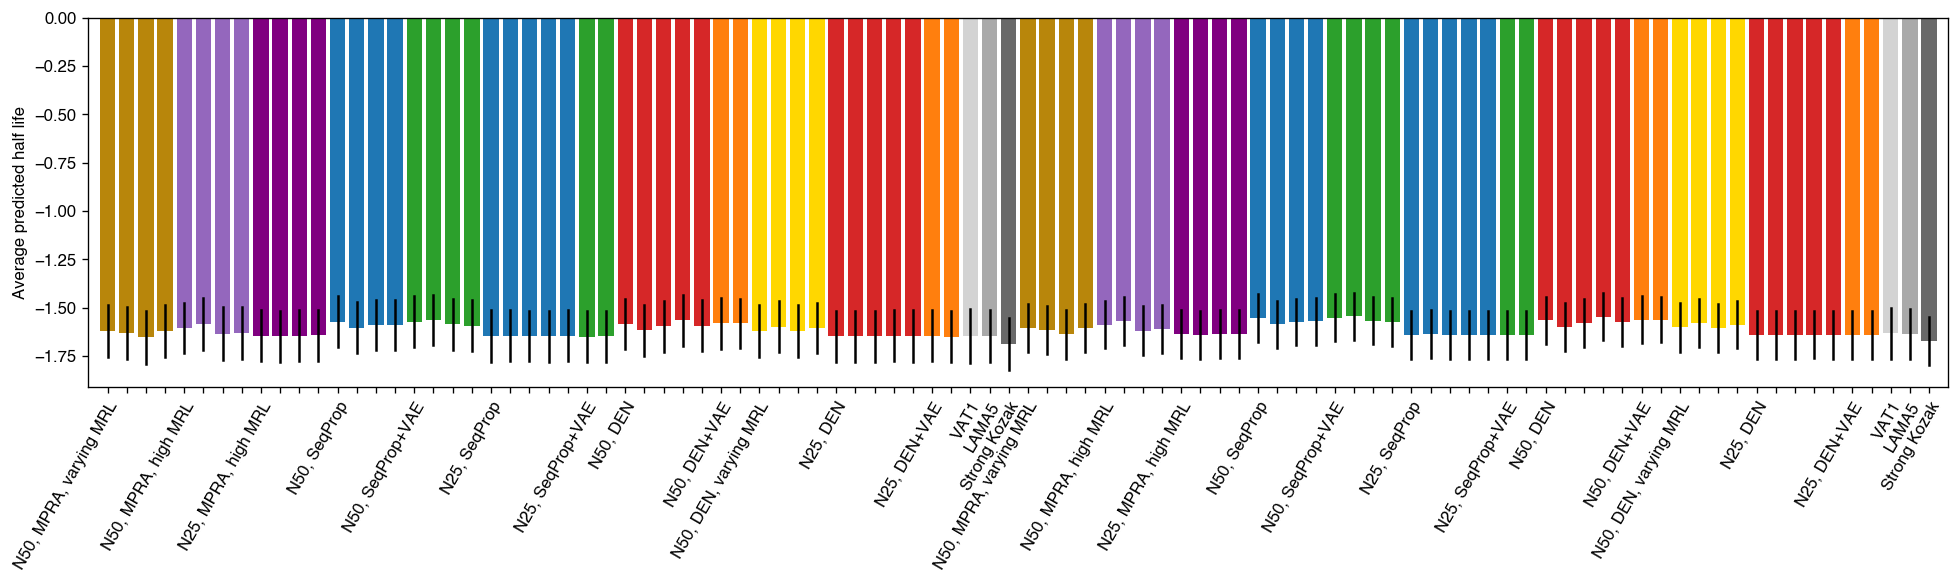

In [21]:
# Make list of colors
seq_colors = [
    seq_colors_dict[d]
    for d in data_seqs_half_life["Description"].values
]
seq_markers = [
    seq_markers_dict[d]
    for d in data_seqs_half_life["Description"].values
]

fig, ax = pyplot.subplots(figsize=(10/48*len(data_seqs_half_life), 4))

# Plot half lives
# Mean as bar plot
# Stdev as error
ax.bar(
    numpy.arange(1, len(data_seqs_half_life)+1),
    data_seqs_half_life['half_life_mean'].values,
    color=seq_colors,
)
for i, (index, row) in enumerate(data_seqs_half_life.iterrows()):
    ax.plot(
        [i+1, i+1],
        # [row['half_life_mean'], row['half_life_mean'] + row['half_life_std']/2],
        # color=seq_colors[i],
        [row['half_life_mean'] - row['half_life_std']/2, row['half_life_mean'] + row['half_life_std']/2],
        color='k',
    )

# x ticks only when 5'UTR description changes
ax.set_xticks(range(1, len(data_seqs_half_life)+1))
xticklabels = data_seqs_half_life["Description"].values.copy()
for i in range(len(xticklabels) - 1, 0, -1):
    if xticklabels[i]==xticklabels[i-1]:
        xticklabels[i] = ''
ax.set_xticklabels(xticklabels)
pyplot.setp(
    ax.get_xticklabels(),
    rotation=60,
    ha="right",
    rotation_mode="anchor",
)

ax.set_ylabel('Average predicted half life')
ax.set_xlim(0, len(data_seqs_half_life)+1)

fig.savefig(f'half_life_predictions.{plt_fmt}', dpi=200, bbox_inches='tight')

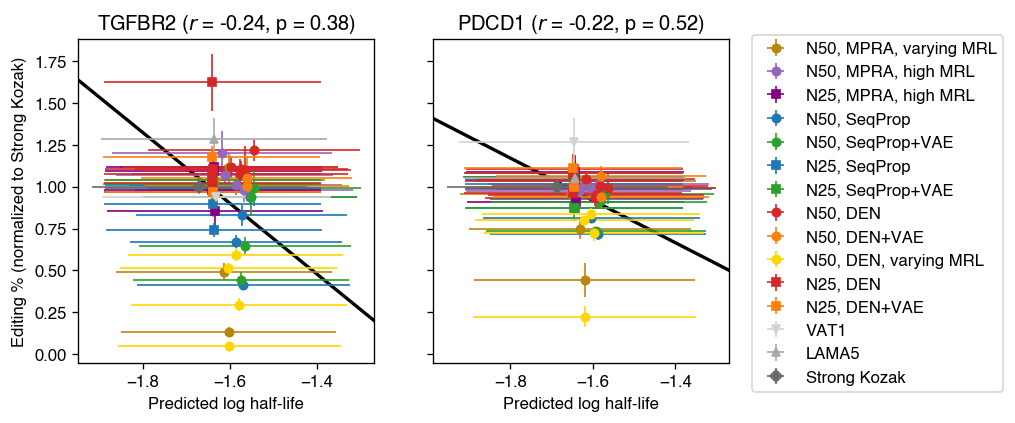

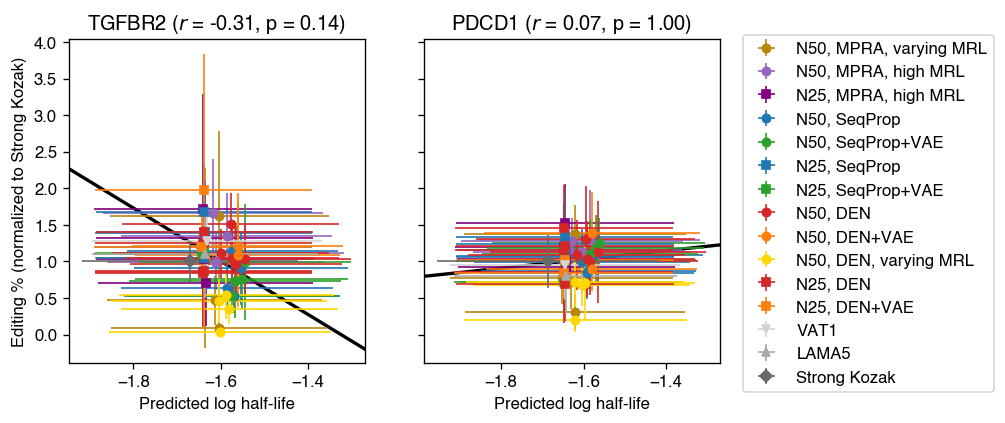

In [22]:
# Plot normalized indel % vs half life
n_tests = len(datasets)*len(megatal_values)
for dataset in datasets:
    data_to_plot = data_indel_half_life[
        data_indel_half_life.index.get_level_values('Dataset')==dataset
    ]

    fig, axes = pyplot.subplots(1, 2, figsize=(3.5*2, 3.5))

    for megatal_idx, megatal in enumerate(megatal_values):
        ax = axes[megatal_idx]

        # Filter data to plot
        data_panel = data_to_plot[(data_to_plot.index.get_level_values('megaTAL')==megatal)]

        # Plot
        for utrtype in data_panel["5'UTR description"].unique():
            data_utrtype = data_panel[data_panel["5'UTR description"]==utrtype]
            ax.errorbar(
                data_utrtype['half_life_mean'].values,
                data_utrtype['Mean normalized indel %'].values,
                xerr=data_utrtype['half_life_std'].values,
                yerr=data_utrtype['Std normalized indel %'].values,
                linestyle='',
                # marker='o',
                marker=seq_markers_dict[utrtype],
                color=seq_colors_dict[utrtype],
                linewidth=1,
                markersize=5,
                label=utrtype,
            )
            
        # Plot linear regression line
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
            data_panel['half_life_mean'].values,
            data_panel['Mean normalized indel %'].values,
        )
        xlim = ax.get_xlim()
        xlim_center = numpy.mean(xlim)
        ax.axline(
            (xlim_center, intercept + slope*xlim_center),
            slope=slope,
            color='k',
            linewidth=2.,
            zorder=-1,
        )
        # Correct p value
        p_value_corrected = min(p_value*n_tests, 1)

        ax.set_title(f"{megatal} ($r$ = {r_value:.2f}, p = {p_value_corrected:.2f})")
        
        if megatal_idx==(len(megatal_values) - 1):
            ax.legend(bbox_to_anchor=(1.05, 1.04))
        
        ax.set_xlabel("Predicted log half-life")
        if megatal_idx==0:
            ax.set_ylabel(f"Editing % (normalized to {norm_seq_desc})")
        else:
            ax.set_yticklabels([])

    ylim = (
        min(axes[0].get_ylim()[0], axes[1].get_ylim()[0]),
        max(axes[0].get_ylim()[1], axes[1].get_ylim()[1]),
    )
    axes[0].set_ylim(ylim)
    axes[1].set_ylim(ylim)

    fig.savefig(f'{dataset}_editing_vs_half_life.{plt_fmt}', dpi=200, bbox_inches='tight')